## <div class="alert alert-block alert-info"><b>Project:</b> Prediction of non-steady-state chloride migration coefficient of concrete</div>

# About the project


**Background:** Several laboratory test methods for measuring the chloride diffusion coefficient of concrete have been proposed. The Nordic standard NT Build 492 is one of the accelerated test procedures for the chloride diffusion coefficient, in which chlorides penetrate the concrete at high speed owing to the used electric field. Although the NT Build 492 test technique provides quick results, the test is typically conducted 28 days after the first test concrete mix is made, as this requires curing. If the first attempt is unsuccessful, the whole process will be repeated and this process will consume more time and resources. The test also requires the help of an experienced operator. All these problems complicate the experimental estimation of the diffusion coefficient of concrete for each project. In another perspective, the conventional simplified models cause the material engineers to overdesign the chloride resistance properties of concrete as a precautionary measure, fearing that they will not provide the desired properties. Therefore, the development of accurate models that determine the chloride diffusion coefficients of concrete, taking into account all influencing parameters, is of crucial importance. 

**Aim:** The aim of the project is to develop a reliable, universal, and robust model to predict the chloride migration coefficient, which will eventually replace the cumbersome, time-consuming, and resource-intensive laboratory test.

**Objectives:** The objectives are twofold: i) developing a machine learning based model to predict the chloride migration coefficient, which takes all influencing parameters into account with a state-of-the-art algorithm and ii) investigating the significance of mix components, fresh and hardened concrete tests to predict chloride migration coefficients.

**Data:** A comprehensive database of 843 experiments investigating the non-steady-state migration coefficients $(D_{nssm})$ of different concrete types is created by collecting from: i) research projects, and ii) internationally published journal articles. The database stored information about the concrete mix, including its fresh and hardened properties.


# Data

The database retained information concerning the concrete mix, its fresh and hardened properties. The concrete mix comprises eight features describing the ingredients type and proportion. These are w/b ratio, contents of binders: cement, slag, FA, SF, and lime filler (unit of $kg/m^3$), amount of fine, coarse, and total aggregates (unit of $kg/m^3$), contents of chemical admixtures: plasticizers, superplasticizers, and air-entraining agents (AEA) in ($\%$ $by$ $binder$ $wt.$). The fresh and hardened properties describe different properties of the concrete specimens. The fresh concrete properties comprise tests of slump and slump flow (unit of $mm$) to describe the workability of the concrete; air content (in $\%$); as well as fresh and dry density (unit of $kg/m^3$). The hardened concrete property test includes test results of comprehensive strength (unit of $MPa$) and non-steady-state migration coefficients (unit of $x10-12 m^2/s$) performed at different maturity ages. The following Table describes the data in greater detail. 

Feature category |No.|Feature subcategory |Description |Unit
-|-|-|-|-
Concrete mix ingredients  |1| Cement types |-|[-]
|2|Water content | - | [kg/m3] 
|3|Cement content  | - | [kg/m3] 
|4|Mineral admixtures content  | Slag | [kg/m3] 
|5| | Fly ash  | [kg/m3] 
|6| | Silica fume | [kg/m3] 
|7| | Lime filler  | [kg/m3] 
|8|Water-to-binder ratio | - | [-]
|9|Aggregates content | Fine aggregate  | [kg/m3] 
|10| | Coarse aggregate  | [kg/m3] 
|11| | Total aggregate | [kg/m3] 
|12|Chemical admixtures content  | Plasticizer | [% by binder wt.]
|13| |Superplasticizer  | [% by binder wt.]
|14| | Air-entraining agent  | [% by binder wt.]
Fresh concrete properties |15| Basic properties |Slump| [mm]
|16| | Spread  |[mm]
|17| | Air content | [-]
|18| | Fresh density  | [kg/m3] 
|19| | Dry density | [kg/m3] 
Hardened concrete properties |20|Mechanical properties |Compressive strength| [MPa]
|21| | Concrete age at compressive strength test |[days]
 |22|Migration properties  |Concrete age at migration test| [days]
 |23| |Migration coefficient $(D_{nssm})$ | [x10-12 m2/s]

# Method

In this project, a state-of-the-art machine learning algorithm called **XGBoost** is used to build a model that predicts a non-steady-state chloride migration coefficient in concrete. Five other tree-based regression algorithms, which are **decision tree** and **ensemble models** (**Random Forest**, **AdaBoost**, **Gradient Boosting**, and **Bagging**), are used to develop  $D_{nssm}$ prediction models for comparison with XGBoost-based models.

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import concat
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import math
import os
import scipy as sp
from scipy.stats import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from math import sqrt

# Retrive the data

In [2]:
# Import the data
df = pd.read_excel('RawData.xlsx')
df.head(3)

,w/b,Water,Cement type,Cement,Slag,Fly ash,Silica fume,Lime filler,Fine aggregate,Coarse aggregate,...,Comp. str. test age,Compressive strength,Air content,Spreed,Slump,Fresh density,Dry density,Migration test age,Dnssm,Migration resistance
0,0.45,180.0,NaN,400.0,0.0,0.0,0.0,0.0,640.0,960.0,...,126.0,63.22,NaN,NaN,NaN,NaN,NaN,120,2.85,Very high
1,0.45,180.0,NaN,380.0,0.0,0.0,20.0,0.0,640.0,960.0,...,126.0,63.46,NaN,NaN,NaN,NaN,NaN,120,1.75,Extremely high
2,0.45,180.0,NaN,360.0,0.0,0.0,40.0,0.0,640.0,960.0,...,126.0,70.88,NaN,NaN,NaN,NaN,NaN,120,0.90,Extremely high


# Data Exploration 

In [3]:
# check the size of the dataframe 
df.shape

(843, 24)

In [4]:
# Check number of nan
df.isnull().sum().sum() 

4818

There are 24 features that represent the proportion of concrete mix ingredients, fresh and hardened properties. To investigate the significance of the fresh and hardened properties in describing the migration coefficients, the model development process is considered into four scenarios. **Scenario 1:** Model development using proportion of mix ingredients, **Scenario 2:** Model development considering mix proportions and fresh properties, **Scenario 3:** Model development considering mix proportions and hardened properties, **Scenario 4:** Model development considering mix proportions as well as fresh and hardened properties.

# Senario 1: Only concrete mix ingrdeints 

## Preprocessing 

In [5]:
# Drop features that represent the fresh and hardened properties of concrete.
df_all_ing = df.drop(df.columns[[14, 15, 16,17,18, 19, 20, 23]], axis=1)

df_all_ing.head(3)

,w/b,Water,Cement type,Cement,Slag,Fly ash,Silica fume,Lime filler,Fine aggregate,Coarse aggregate,Total aggregate,Plasticizer,Superplasticizer,Air entraining,Migration test age,Dnssm
0,0.45,180.0,NaN,400.0,0.0,0.0,0.0,0.0,640.0,960.0,1600.0,0.0,0.0,0.0,120,2.85
1,0.45,180.0,NaN,380.0,0.0,0.0,20.0,0.0,640.0,960.0,1600.0,0.0,0.0,0.0,120,1.75
2,0.45,180.0,NaN,360.0,0.0,0.0,40.0,0.0,640.0,960.0,1600.0,0.0,0.0,0.0,120,0.90


### Handling of missed data

In [6]:
# Check number of nan
df_all_ing.isnull().sum().sum() 

1462

In [7]:
# Drop all rows with NaN values and reset index after drop
df_all_ing = df_all_ing.dropna().reset_index(drop=True)
df_all_ing.head(3)

,w/b,Water,Cement type,Cement,Slag,Fly ash,Silica fume,Lime filler,Fine aggregate,Coarse aggregate,Total aggregate,Plasticizer,Superplasticizer,Air entraining,Migration test age,Dnssm
0,0.55,192.5,CEM I,350.0,0.0,0.0,0.0,0.0,699.988,1062.249,1762.237,0.0,0.0,0.0,28,17.0
1,0.55,192.5,CEM II/A-D,329.0,0.0,0.0,21.0,0.0,694.766,1059.600,1754.366,0.0,0.0,0.0,28,14.2
2,0.55,192.5,CEM II/A-V,297.5,0.0,52.5,0.0,0.0,692.233,1056.951,1749.184,0.0,0.0,0.0,28,23.3


In [8]:
# Sanity check
df_all_ing.isnull().sum().sum() 

0

In [9]:
# check the size of a dataframe "df_all_ing"
df_all_ing.shape

(204, 16)

In [10]:
# computes and displays summary statistics for dataframe "df_all_ing"
df_all_ing.describe()

,w/b,Water,Cement,Slag,Fly ash,Silica fume,Lime filler,Fine aggregate,Coarse aggregate,Total aggregate,Plasticizer,Superplasticizer,Air entraining,Migration test age,Dnssm
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.0,204.000000,204.000000,204.000000,204.0,204.000000,204.0,204.000000,204.000000
mean,0.424000,175.991176,361.850000,18.438725,44.122059,8.361765,0.0,798.830755,797.205485,1596.036240,0.0,0.414598,0.0,65.568627,11.226025
std,0.079792,22.640191,96.903092,57.348913,133.697922,35.459964,0.0,223.797309,306.175360,291.545939,0.0,0.541004,0.0,83.702147,14.637738
min,0.300000,122.500000,52.000000,0.000000,0.000000,0.000000,0.0,235.000000,0.000000,630.000000,0.0,0.000000,0.0,3.000000,0.744000
25%,0.360000,158.000000,297.875000,0.000000,0.000000,0.000000,0.0,685.258250,451.500000,1415.820000,0.0,0.000000,0.0,28.000000,5.185000
50%,0.400000,175.000000,350.000000,0.000000,0.000000,0.000000,0.0,765.000000,915.530000,1720.000000,0.0,0.200000,0.0,28.000000,7.302500
75%,0.450000,191.000000,444.375000,0.000000,0.000000,0.000000,0.0,956.750000,1059.950000,1801.000000,0.0,0.700000,0.0,90.000000,10.522500
max,0.651786,222.000000,525.000000,312.300000,735.000000,468.500000,0.0,1574.100000,1240.000000,1950.000000,0.0,4.166667,0.0,365.000000,133.600000


### Data exploration through visualization 

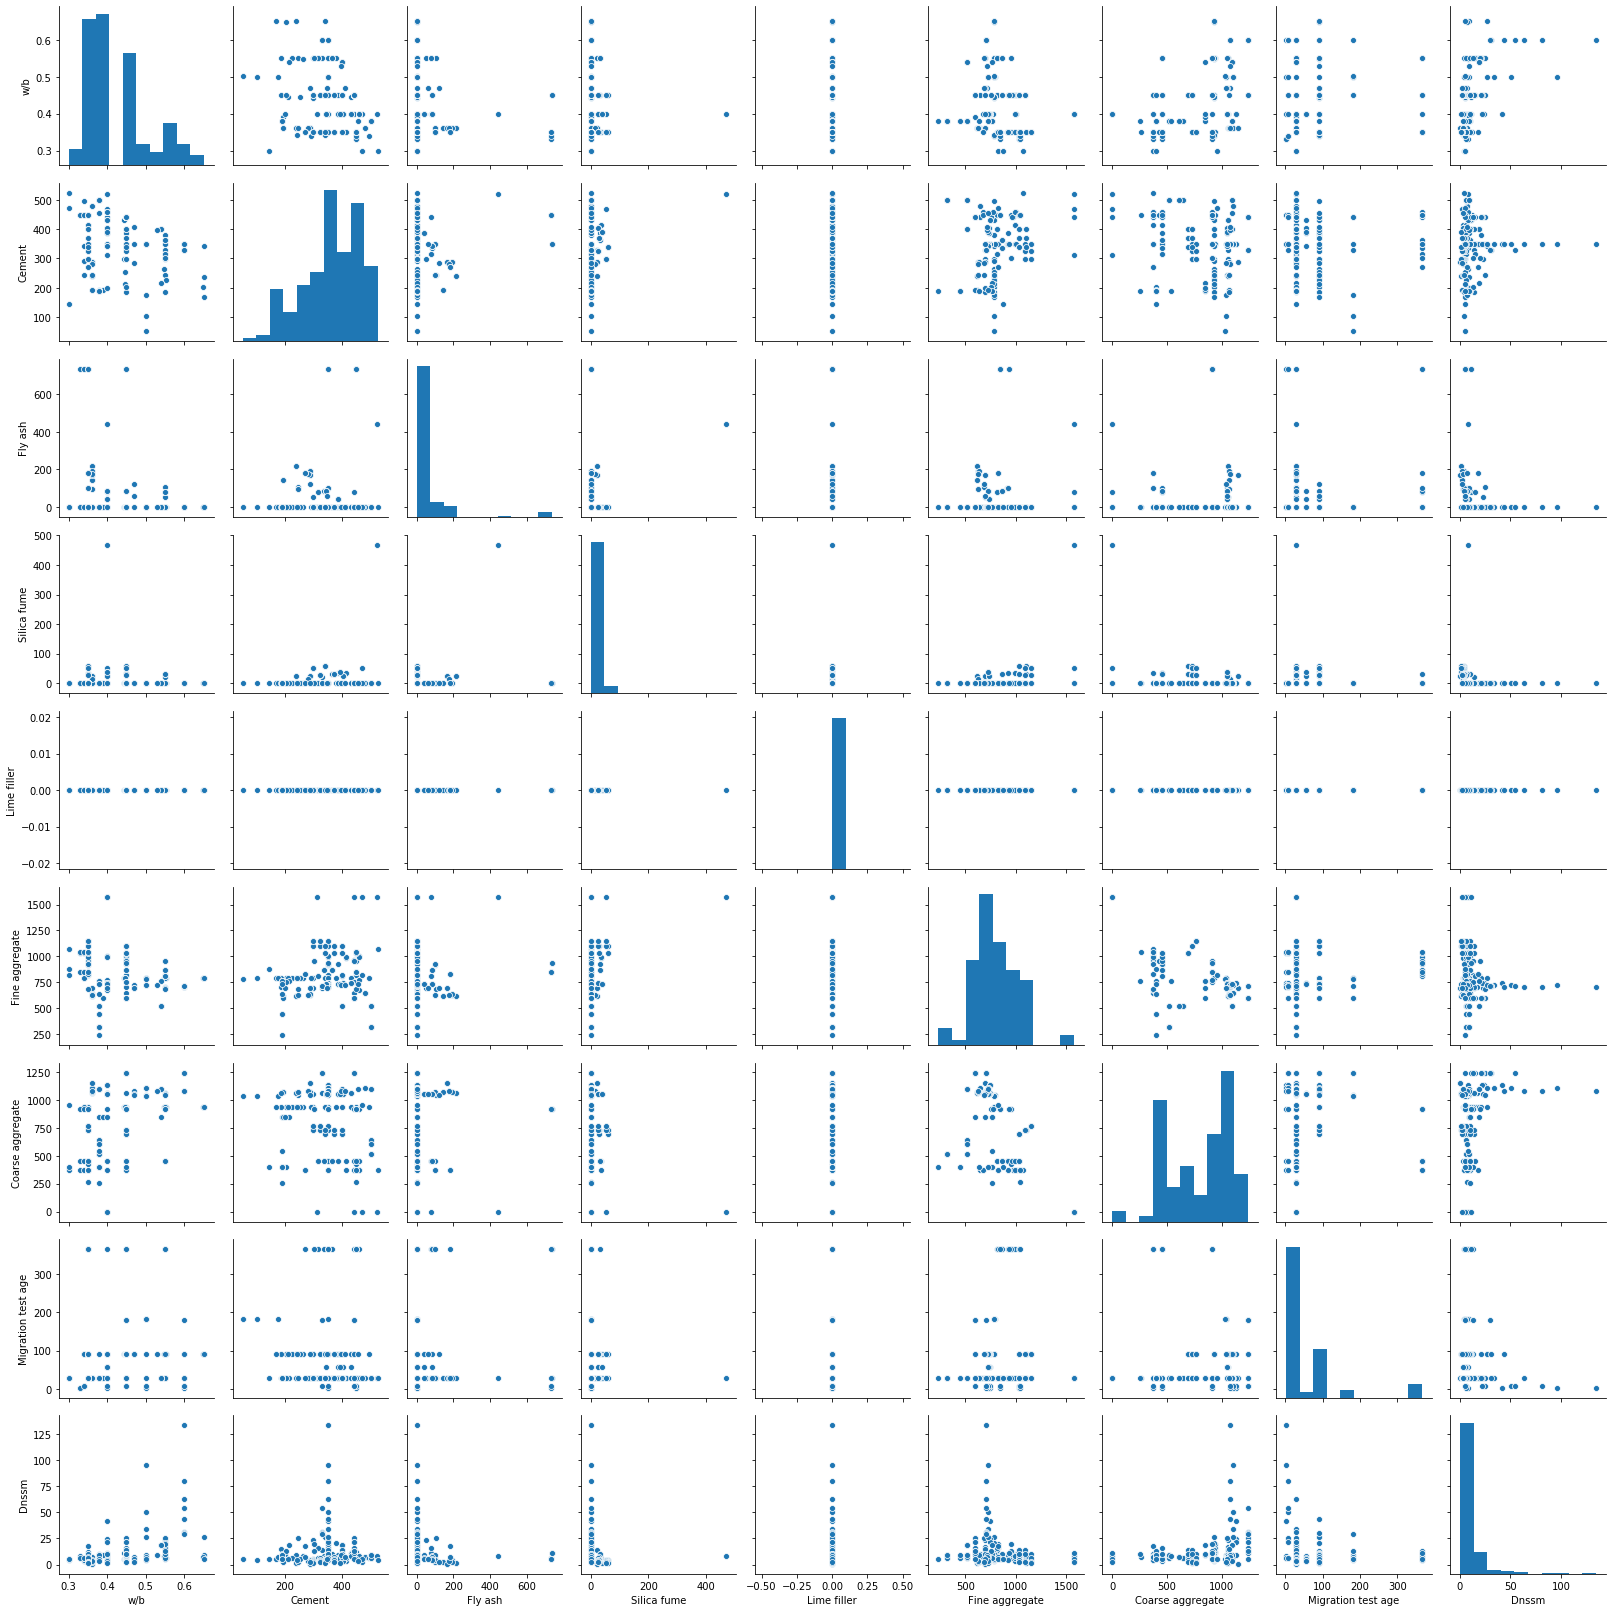

In [11]:
# Select features to be visualize

cols = ['w/b', 'Cement', 'Fly ash', 'Silica fume', 'Lime filler','Fine aggregate', 'Coarse aggregate', 'Migration test age', 'Dnssm']
sns.pairplot(df_all_ing[cols], height=2.5)
#sns.pairplot(df_all_ing_enc, height=2.5)
plt.tight_layout()
plt.show()

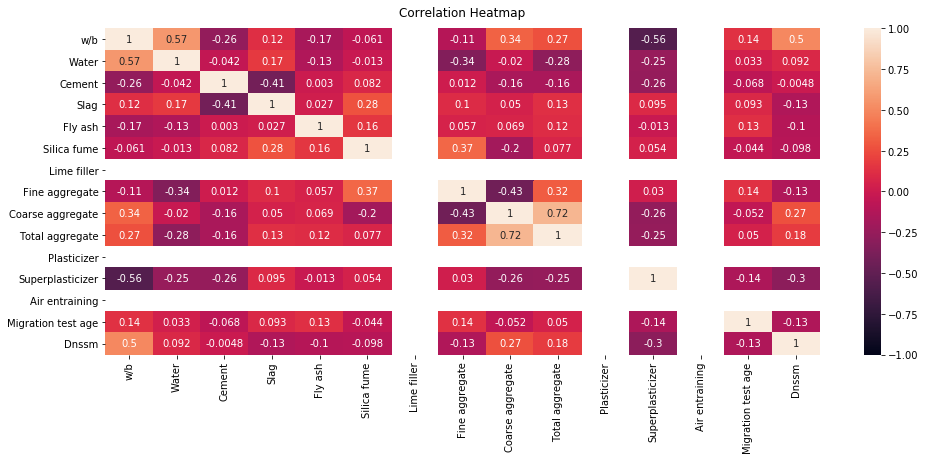

In [12]:
# Plot correlation heatmap
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(df_all_ing.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [13]:
# Write the prediction in an Excel sheet to visualize with another tool.
df_all_ing.to_excel("df_all_ing_corr.xlsx",sheet_name='Corr')  

It can be noticed from the pair plot and a heat map that features (Lime filler, Plasticizer, and Air entraining) have only zero values after all NaN are removed from the dataframe. Hence, these features are useless for the analysis.

Extreme values are also observed in some of the features, which shall be treated before training the data.

In [14]:
df_all_ing.describe()

,w/b,Water,Cement,Slag,Fly ash,Silica fume,Lime filler,Fine aggregate,Coarse aggregate,Total aggregate,Plasticizer,Superplasticizer,Air entraining,Migration test age,Dnssm
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.0,204.000000,204.000000,204.000000,204.0,204.000000,204.0,204.000000,204.000000
mean,0.424000,175.991176,361.850000,18.438725,44.122059,8.361765,0.0,798.830755,797.205485,1596.036240,0.0,0.414598,0.0,65.568627,11.226025
std,0.079792,22.640191,96.903092,57.348913,133.697922,35.459964,0.0,223.797309,306.175360,291.545939,0.0,0.541004,0.0,83.702147,14.637738
min,0.300000,122.500000,52.000000,0.000000,0.000000,0.000000,0.0,235.000000,0.000000,630.000000,0.0,0.000000,0.0,3.000000,0.744000
25%,0.360000,158.000000,297.875000,0.000000,0.000000,0.000000,0.0,685.258250,451.500000,1415.820000,0.0,0.000000,0.0,28.000000,5.185000
50%,0.400000,175.000000,350.000000,0.000000,0.000000,0.000000,0.0,765.000000,915.530000,1720.000000,0.0,0.200000,0.0,28.000000,7.302500
75%,0.450000,191.000000,444.375000,0.000000,0.000000,0.000000,0.0,956.750000,1059.950000,1801.000000,0.0,0.700000,0.0,90.000000,10.522500
max,0.651786,222.000000,525.000000,312.300000,735.000000,468.500000,0.0,1574.100000,1240.000000,1950.000000,0.0,4.166667,0.0,365.000000,133.600000


In [15]:
# write df_all_ing into excel to visualize with another tool.
df_all_ing.to_excel("df_all_ing.xlsx")  

In [16]:
cols1 = ['w/b']
cols2 = ['Water','Cement', 'Fly ash', 'Silica fume','Fine aggregate', 'Coarse aggregate','Superplasticizer']
cols3 = ['Migration test age']
cols4 = ['Dnssm']

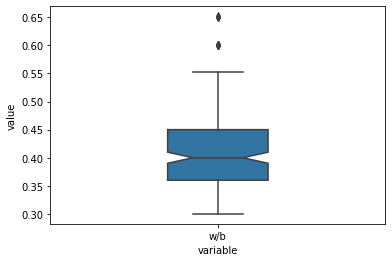

In [17]:
sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing[cols1]), width= 0.3,notch= True)

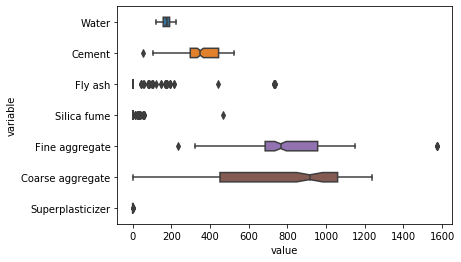

In [18]:
sns.boxplot(y="variable", x="value", data=pd.melt(df_all_ing[cols2]), width= 0.3,notch= True)

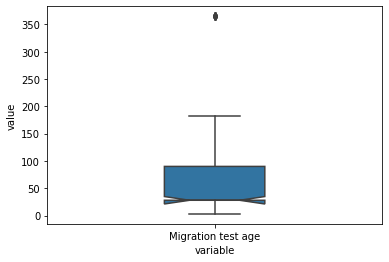

In [19]:
sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing[cols3]), width= 0.3,notch= True)

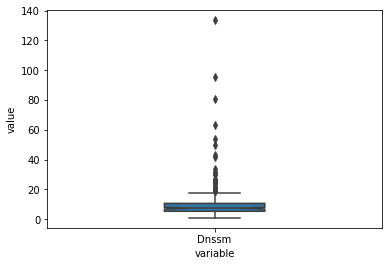

In [20]:
sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing[cols4]), width= 0.3,notch= True)

### Outlier detection 

Adoption of the multivariate outlier detection method is essential to identify situations in which two or more features have an uncommon combination of scores. Let's apply Mahalanobis distance to detect outliers.

Removing string and columns with all same values shall be omitted from the data before applying Mahalanobis distance. That means features *'Cement type', 'Lime filler', 'Plasticizer', 'Air entraining'* must be discarded from the data since the feature cement types which is a string type and the other files have only zero values.

In [21]:
# Remove unnecessary  features 

df_all_ing1 = df_all_ing.drop(columns=['Cement type','Lime filler','Plasticizer','Air entraining'])
df_all_ing1.head(2)

,w/b,Water,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Total aggregate,Superplasticizer,Migration test age,Dnssm
0,0.55,192.5,350.0,0.0,0.0,0.0,699.988,1062.249,1762.237,0.0,28,17.0
1,0.55,192.5,329.0,0.0,0.0,21.0,694.766,1059.600,1754.366,0.0,28,14.2


In [22]:
#Define a function to calculate Mahalanobis Distance.
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [23]:
df_all_ing1['Mahal. Dis.'] = mahalanobis(x=df_all_ing1, data=df_all_ing1)
df_all_ing1['Cement type']= df_all_ing['Cement type']
df_all_ing1.head(2)

,w/b,Water,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Total aggregate,Superplasticizer,Migration test age,Dnssm,Mahal. Dis.,Cement type
0,0.55,192.5,350.0,0.0,0.0,0.0,699.988,1062.249,1762.237,0.0,28,17.0,4.429580,CEM I
1,0.55,192.5,329.0,0.0,0.0,21.0,694.766,1059.600,1754.366,0.0,28,14.2,5.280705,CEM II/A-D


The crucial value at a 0.01 significance level and 2 degrees of freedom is computed as follows, assuming the test statistic is chi-square distributed with 'n' degrees of freedom: 

In [24]:
# Remove extreme values for two degrees of freedom with a significance level of 0.01
df_all_ing1 = df_all_ing1[df_all_ing1['Mahal. Dis.'] < chi2.ppf((1-0.01), df=2)]
df_all_ing_out = df_all_ing1.drop(columns=['Mahal. Dis.'])
df_all_ing_out.head(2)

,w/b,Water,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Total aggregate,Superplasticizer,Migration test age,Dnssm,Cement type
0,0.55,192.5,350.0,0.0,0.0,0.0,699.988,1062.249,1762.237,0.0,28,17.0,CEM I
1,0.55,192.5,329.0,0.0,0.0,21.0,694.766,1059.600,1754.366,0.0,28,14.2,CEM II/A-D


In [25]:
df_all_ing_out.shape

(134, 13)

### Encoding Categorical Data 

In [26]:
# Examine  the data types of all features considered in the dataframe
df_all_ing_out.dtypes

w/b                   float64
Water                 float64
Cement                float64
Slag                  float64
Fly ash               float64
Silica fume           float64
Fine aggregate        float64
Coarse aggregate      float64
Total aggregate       float64
Superplasticizer      float64
Migration test age      int64
Dnssm                 float64
Cement type            object
dtype: object

It can be noticed that the data types of all the features are float except for the feature cement type. The data type of this feature shall be converted from *object* to *category* for encoding.

Let's examine all types of unique values in the Cem_type column in the original (raw) and preprocessed datasets.

In [27]:
df['Cement type'].unique()

array([nan, 'CEM I', 'CEM II/A-D', 'CEM II/A-V', 'CEM II/B-V',
       'CEM II/A-L', 'CEM II/B-L', 'CEM II/B-S', 'CEM II/A-M',
       'CEM II/A-LL', 'CEM II/B-M', 'CEM III/A', 'CEM IV/A', 'CEM IV/B',
       'CEM II/A-S', 'CEM III/B'], dtype=object)

In [28]:
df_all_ing_out['Cement type'].unique()

array(['CEM I', 'CEM II/A-D', 'CEM II/A-V', 'CEM II/B-V', 'CEM III/A',
       'CEM II/B-S', 'CEM IV/A'], dtype=object)

In the original dataset, there are 14 types of cement types, which can be grouped into five main types (CEM I, CEM II, CEM III, CEM IV, and CEM V). Whereas in the preprocessed data there are only seven types of cement. Although cement types are categorized into five main groups, the group numbering has no orders or scales. Therefore, the cement type categorical data is considered **nominal** and not ordinal. **One-hot encodin** is the right choice to convert categorical data (with nominal data type) to numeric data. It maps each category with binary numbers (0 or 1).

Now let's convert a "Cement type" column to a category as it is a prerequisite for encoding.

In [29]:
df_all_ing_out["Cement type"] = df_all_ing_out["Cement type"].astype('category')

In [30]:
# Sanity check
df_all_ing_out.dtypes

w/b                    float64
Water                  float64
Cement                 float64
Slag                   float64
Fly ash                float64
Silica fume            float64
Fine aggregate         float64
Coarse aggregate       float64
Total aggregate        float64
Superplasticizer       float64
Migration test age       int64
Dnssm                  float64
Cement type           category
dtype: object

#### One-Hot Encoding

In [31]:
# Convert the values in the Cem_type_cat column into one-hot encoded vectors
df_all_ing_out_enc=pd.get_dummies(df_all_ing_out, columns=["Cement type"])
df_all_ing_out_enc.head(2)

,w/b,Water,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Total aggregate,Superplasticizer,Migration test age,Dnssm,Cement type_CEM I,Cement type_CEM II/A-D,Cement type_CEM II/A-V,Cement type_CEM II/B-S,Cement type_CEM II/B-V,Cement type_CEM III/A,Cement type_CEM IV/A
0,0.55,192.5,350.0,0.0,0.0,0.0,699.988,1062.249,1762.237,0.0,28,17.0,1,0,0,0,0,0,0
1,0.55,192.5,329.0,0.0,0.0,21.0,694.766,1059.600,1754.366,0.0,28,14.2,0,1,0,0,0,0,0


In [32]:
# Shift column 'Dnssm' to end position
end_column = df_all_ing_out_enc.pop('Dnssm')

# Determine the postion
position_all_ing = len(df_all_ing_out_enc.columns)
 
# Insert column using insert(position,column_name,end_column) function

df_all_ing_out_enc.insert(position_all_ing, 'Dnssm', end_column)
df_all_ing_out_enc.head(3)

,w/b,Water,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Total aggregate,Superplasticizer,Migration test age,Cement type_CEM I,Cement type_CEM II/A-D,Cement type_CEM II/A-V,Cement type_CEM II/B-S,Cement type_CEM II/B-V,Cement type_CEM III/A,Cement type_CEM IV/A,Dnssm
0,0.55,192.5,350.0,0.0,0.0,0.0,699.988,1062.249,1762.237,0.0,28,1,0,0,0,0,0,0,17.0
1,0.55,192.5,329.0,0.0,0.0,21.0,694.766,1059.600,1754.366,0.0,28,0,1,0,0,0,0,0,14.2
2,0.55,192.5,297.5,0.0,52.5,0.0,692.233,1056.951,1749.184,0.0,28,0,0,1,0,0,0,0,23.3


In [33]:
# examine shape of the new dataframe
df_all_ing_out_enc.shape

(134, 19)

### Feature selection

One of the most important processes in the pipeline for building machine learning models is determining feature importance. This is because the selection of key features leads to models with low computational effort and lower generalization error due to noises introduced by less significant features. 

It is possible to use a random forest to measure feature importance without making any assumptions about whether or not the data is linearly separable, because the averaged impurity decrease computed from all decision trees in the forest.

Let's apply **Random Forest** to meaure feature importance.

In [34]:
# load input and target features
X = df_all_ing_out_enc.iloc[:,0:-1]
y = df_all_ing_out_enc.iloc[:,-1]

In [35]:
# Spit the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [36]:
# Train the model using Sklearn RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [37]:
# Determine feature importance values
rf.feature_importances_

array([2.84301921e-01, 1.34203755e-01, 3.79597248e-02, 6.90217336e-03,
       1.31275576e-02, 5.38668123e-02, 3.39752845e-02, 2.84282556e-01,
       3.91916272e-02, 3.51028280e-02, 6.11101159e-02, 5.73402415e-03,
       8.54437569e-04, 7.09896932e-04, 7.59393956e-05, 1.86018685e-03,
       4.00229683e-03, 2.73886303e-03])

Text(0.5, 0, 'Random Forest Feature Importance')

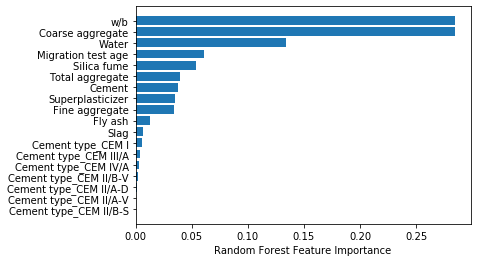

In [38]:
# Let’s sort the plot the importances (chart will be easier to interpret than values).
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Write the prediction in an Excel spreadsheet to visualize it with another tool.


In [39]:
# Transform array to DataFrame
Features = pd.DataFrame(X.columns[sorted_idx])
Score =  pd.DataFrame(rf.feature_importances_[sorted_idx])
Feature_Importance = pd.concat([Features, Score], axis=1) 

# Write the prediction in an Excel sheet to visualize with another tool.

Feature_Importance.to_excel("Feature_Importance.xlsx",sheet_name='Corr')  

Text(0.5, 0, 'Random Forest Feature Importance')

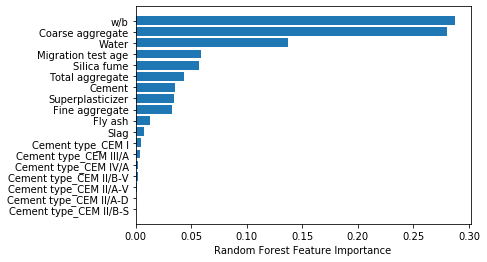

In [40]:
# load input and target features
X = df_all_ing_out_enc.iloc[:,0:-1]
y = df_all_ing_out_enc.iloc[:,-1]

# Spit the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

# Train the model using Sklearn RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(X_train, y_train)


# Determine feature importance values
rf.feature_importances_

# Let’s sort the plot the importances (chart will be easier to interpret than values).
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

It can be observed from the feature importance measure that the feature w/b and superplasticizer are the most significant features that control the chloride migration into concrete in the considered cases. Supplementary cementitious materials (*Slag*, *Fly ash*, and *Silica fume*) are identified as non-influential parameter. This is because their information is already encoded by the feature *w/b*.  This feature also comprises information about water. Hence, features (*w/b, Cement, Fine aggregate, Coarse aggregate, Superplasticizer, Migration test age, Cement type_CEM I, and Cemenet type_CEM IV/A*) could be selected as $D_{nssm}$ predictors.

In [41]:
df_all_ing_out_enc.columns

Index(['w/b', 'Water', 'Cement', 'Slag', 'Fly ash', 'Silica fume',
       'Fine aggregate', 'Coarse aggregate', 'Total aggregate',
       'Superplasticizer', 'Migration test age', 'Cement type_CEM I',
       'Cement type_CEM II/A-D', 'Cement type_CEM II/A-V',
       'Cement type_CEM II/B-S', 'Cement type_CEM II/B-V',
       'Cement type_CEM III/A', 'Cement type_CEM IV/A', 'Dnssm'],
      dtype='object')

In [42]:
# select the desired features 
df_all_ing_out_enc_FS = df_all_ing_out_enc.loc[:, ['w/b', 'Cement','Slag', 'Fly ash', 'Silica fume',
                                                   'Fine aggregate','Coarse aggregate','Superplasticizer',
                                                   'Migration test age', 'Cement type_CEM I','Cement type_CEM II/A-D', 
                                                   'Cement type_CEM II/A-V','Cement type_CEM II/B-S', 
                                                   'Cement type_CEM II/B-V','Cement type_CEM III/A', 
                                                   'Cement type_CEM IV/A','Dnssm']]

In [43]:
df_all_ing_out_enc_FS.describe()

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Migration test age,Cement type_CEM II/A-D,Cement type_CEM II/A-V,Cement type_CEM II/B-S,Cement type_CEM II/B-V,Cement type_CEM III/A,Cement type_CEM IV/A,Dnssm
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,0.420403,387.488806,4.186567,22.203731,7.822388,807.582642,835.342754,0.337589,45.350746,0.007463,0.007463,0.014925,0.007463,0.029851,0.022388,9.702231
std,0.070229,70.164468,24.248763,53.823640,15.650060,192.535456,284.622329,0.369789,32.706546,0.086387,0.086387,0.121709,0.086387,0.170814,0.148497,7.675932
min,0.300000,225.000000,0.000000,0.000000,0.000000,517.000000,266.350000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.744000
25%,0.360000,341.000000,0.000000,0.000000,0.000000,681.752750,607.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.375000
50%,0.400000,391.000000,0.000000,0.000000,0.000000,743.000000,934.000000,0.175000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000
75%,0.450000,450.000000,0.000000,0.000000,0.000000,1002.500000,1065.062250,0.665356,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.547500
max,0.600000,525.000000,170.000000,216.000000,60.000000,1150.000000,1240.000000,1.010101,182.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50.050000


In [44]:
df_all_ing_out_enc_FS.shape

(134, 16)

# Model training

## XGBoost

In [45]:
# selected features after outliers removed 
start_time = datetime.now()
X = df_all_ing_out_enc_FS.iloc[:,0:-1].values
y = df_all_ing_out_enc_FS.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

#Prepare and train the model

model = XGBRegressor()

## grid search to find the best model parameter

param_grid = {
        'n_estimators': [20, 50, 100, 300,500],
        'max_depth': [2, 4, 6, 8, 10],
        'gamma': [0.0001, 0.001, 0.01],
        'learning_rate': [0.001, 0.01, 0.1, 0.3],
        'booster': ['gbtree']}

grid_search_model = GridSearchCV(model, param_grid=param_grid, cv=5, return_train_score=True, n_jobs=-1)
grid_search_model.fit(X_train, y_train)

print(f'Best Score: {grid_search_model.best_score_}')
print(f'Best Param: {grid_search_model.best_params_}')

## fitting the best model

best_model = grid_search_model.best_estimator_

best_model.fit(X_train, y_train)
end_time = datetime.now()

print(f'Train Score: {best_model.score(X_train, y_train)}')
print(f'Test Score: {best_model.score(X_test, y_test)}')
print('XGBoost: Duration: {}'.format(end_time - start_time))

Best Score: 0.7768004529405645
Best Param: {'booster': 'gbtree', 'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}
Train Score: 0.9900537432435743
Test Score: 0.829799609703172
XGBoost: Duration: 0:00:37.330666


### XGBoost Model evaluation

In [46]:
y_pred = best_model.predict(X_test)

In [47]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred)))

Mean Absolute Error (MAE): 1.982
Mean Squared Error (MSE):  9.992
RMSE: 3.161
R2 Score: 0.830


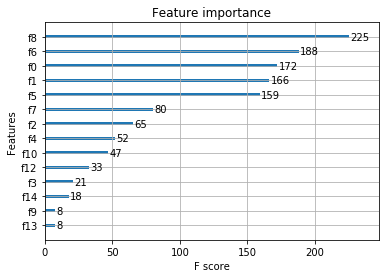

In [48]:
xgb.plot_importance(best_model)

In [49]:
df_all_ing_out_enc_FS.columns

Index(['w/b', 'Cement', 'Slag', 'Fly ash', 'Silica fume', 'Fine aggregate',
       'Coarse aggregate', 'Superplasticizer', 'Migration test age',
       'Cement type_CEM II/A-D', 'Cement type_CEM II/A-V',
       'Cement type_CEM II/B-S', 'Cement type_CEM II/B-V',
       'Cement type_CEM III/A', 'Cement type_CEM IV/A', 'Dnssm'],
      dtype='object')

## Random Forest

In [50]:
start_time = datetime.now()

rf = RandomForestRegressor()

parameters_rf = {'bootstrap': [True],
                'max_depth': [80, 90, 100, 110],
                'max_features':['auto', 'sqrt', 'log2'],
                'min_samples_leaf': [3, 4, 5],
                'min_samples_split': [8, 10, 12],
                'n_estimators': [100, 200, 300, 1000]}

grid_search_rf = GridSearchCV(rf, param_grid = parameters_rf,cv = 5, n_jobs = -1, verbose = 2)
grid_search_rf.fit(X_train, y_train)

print(f'Best Score: {grid_search_rf.best_score_}')
print(f'Best Param: {grid_search_rf.best_params_}')

## fitting the best model

best_grid_rf = grid_search_rf.best_estimator_
best_grid_rf.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_rf.score(X_train, y_train)}')
print(f'Test Score: {best_grid_rf.score(X_test, y_test)}')
print('Random Forest: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  6.9min finished


Best Score: 0.6101755170120257
Best Param: {'bootstrap': True, 'max_depth': 90, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
Train Score: 0.824378612635319
Test Score: 0.9176833142090067
Random Forest: Duration: 0:06:53.003588


### Random Forest Model evaluation

In [51]:
y_pred_rf = best_grid_rf.predict(X_test)

In [52]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_rf)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_rf)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_rf)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_rf)))

Mean Absolute Error (MAE): 1.617
Mean Squared Error (MSE):  4.833
RMSE: 2.198
R2 Score: 0.918


## Decision Tree

In [53]:
start_time = datetime.now()
dtr=DecisionTreeRegressor()

parameters_dtr={'splitter':['best','random'],
            'max_depth' : [2,3,4,5,6,7,8],
           'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
           'min_samples_split': [2,3,4,5,6,7,8,9,10], 
           'max_features':['auto','log2','sqrt',None],
           'max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90] }

grid_search_dtr = GridSearchCV(dtr,param_grid=parameters_dtr,cv=5,n_jobs = -1,verbose=3)
grid_search_dtr.fit(X_train, y_train)

print(f'Best Score: {grid_search_dtr.best_score_}')
print(f'Best Param: {grid_search_dtr.best_params_}')

## fitting the best model

best_grid_dtr = grid_search_dtr.best_estimator_
best_grid_dtr.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_dtr.score(X_train, y_train)}')
print(f'Test Score: {best_grid_dtr.score(X_test, y_test)}')
print('Decsion Tree: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 50400 candidates, totalling 252000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2808 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 7928 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 19192 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 37624 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 60152 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 86776 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 117496 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 152312 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 191224 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 234232 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 252000 out of 252000 | elapsed:  4.0min finished


Best Score: 0.6977198348904957
Best Param: {'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
Train Score: 0.48118385344714165
Test Score: 0.6633767885783375
Decsion Tree: Duration: 0:04:01.718654


### Decision Tree Model evaluation

In [54]:
y_pred_dtr = best_grid_dtr.predict(X_test)

In [55]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_dtr)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_dtr)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_dtr)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_dtr)))

Mean Absolute Error (MAE): 3.245
Mean Squared Error (MSE):  19.762
RMSE: 4.445
R2 Score: 0.663


## AdaBoost Regressor

In [56]:
start_time = datetime.now()

adbr = AdaBoostRegressor()
parameters_adbr={'learning_rate':[0.05,0.1,0.2,0.6,0.8,1],
                'n_estimators': [50,60,100],
                'loss' : ['linear', 'square', 'exponential']}

grid_search_adbr=GridSearchCV(adbr, param_grid=parameters_adbr,cv=5,n_jobs = -1, verbose=3)
grid_search_adbr.fit(X_train, y_train)

print(f'Best Score: {grid_search_adbr.best_score_}')
print(f'Best Param: {grid_search_adbr.best_params_}')

## fitting the best model

best_grid_adbr = grid_search_adbr.best_estimator_
best_grid_adbr.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_adbr.score(X_train, y_train)}')
print(f'Test Score: {best_grid_adbr.score(X_test, y_test)}')
print('AdaBoost Regressor: Duration: {}'.format(end_time - start_time))


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 263 out of 270 | elapsed:   11.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   12.0s finished


Best Score: 0.6118097769162454
Best Param: {'learning_rate': 1, 'loss': 'exponential', 'n_estimators': 60}
Train Score: 0.9044794971590195
Test Score: 0.8685630154741449
AdaBoost Regressor: Duration: 0:00:12.281408


### AdaBoost Model Evaluation

In [57]:
y_pred_adbr = best_grid_adbr.predict(X_test)

In [58]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_adbr)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_adbr)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_adbr)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_adbr)))

Mean Absolute Error (MAE): 2.019
Mean Squared Error (MSE):  7.716
RMSE: 2.778
R2 Score: 0.869


## Gradient Boosting

In [59]:
start_time = datetime.now()

gbr = GradientBoostingRegressor()

parameters_gbr = {'max_depth': [3,5,6,7],
              'max_features':['auto', 'sqrt', 'log2'],
              'min_samples_split': [2, 3, 10],
              'min_samples_leaf': [1, 3, 10],
            'learning_rate':[0.05,0.1,0.2],
            'n_estimators': [10,30,50,70]}

grid_search_gbr = GridSearchCV(gbr, param_grid=parameters_gbr,cv=5,n_jobs = -1, verbose=3)
grid_search_gbr.fit(X_train, y_train)

print(f'Best Score: {grid_search_gbr.best_score_}')
print(f'Best Param: {grid_search_gbr.best_params_}')

## fitting the best model

best_grid_gbr = grid_search_gbr.best_estimator_
best_grid_gbr.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_gbr.score(X_train, y_train)}')
print(f'Test Score: {best_grid_gbr.score(X_test, y_test)}')
print('Gradient Boosting Regressor: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 5880 tasks      | elapsed:   45.1s


Best Score: 0.8196556935030866
Best Param: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 70}
Train Score: 0.9795225814012639
Test Score: 0.9017879859837805
Gradient Boosting Regressor: Duration: 0:00:50.039097


[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:   49.8s finished


### Gradient Boosting Model Evaluation

In [60]:
y_pred_gbr = best_grid_gbr.predict(X_test)

In [61]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_gbr)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_gbr)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_gbr)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_gbr)))

Mean Absolute Error (MAE): 1.584
Mean Squared Error (MSE):  5.766
RMSE: 2.401
R2 Score: 0.902


## Bagging

In [62]:
start_time = datetime.now()

br = BaggingRegressor()

parameters_br = {'n_estimators': [50,100,200],
              'max_features':[1,2,4,6,8],
              'max_samples': [0.5,0.1],
            'bootstrap': [True, False],
         'bootstrap_features': [True, False]}


grid_search_br = GridSearchCV(br, param_grid=parameters_br,cv=5,n_jobs = -1, verbose=3)
grid_search_br.fit(X_train, y_train)

print(f'Best Score: {grid_search_br.best_score_}')
print(f'Best Param: {grid_search_br.best_params_}')

## fitting the best model

best_grid_br = grid_search_br.best_estimator_
best_grid_br.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_br.score(X_train, y_train)}')
print(f'Test Score: {best_grid_br.score(X_test, y_test)}')
print('Bagging Regressor: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   36.0s finished


Best Score: 0.6319785560056416
Best Param: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 8, 'max_samples': 0.5, 'n_estimators': 200}
Train Score: 0.8454233954718526
Test Score: 0.8422690995502499
Bagging Regressor: Duration: 0:00:36.685807


In [63]:
## Gradient Boosting Model Evaluation

In [64]:
y_pred_br = best_grid_br.predict(X_test)

In [65]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_br)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_br)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_br)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_br)))

Mean Absolute Error (MAE): 2.034
Mean Squared Error (MSE):  9.260
RMSE: 3.043
R2 Score: 0.842


### XGBoost Model Output Visualization

### Training

In [66]:
y_pred_train_all = best_model.predict(X_train)

In [67]:
true_pred_all_train= pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_pred_train_all),
                            pd.DataFrame(y_train)- pd.DataFrame(y_pred_train_all)], axis=1)
true_pred_all_train.columns =['Actual', 'Predicted','Residuals']
true_pred_all_train.head(2)

,Actual,Predicted,Residuals
0,9.900,10.443737,-0.543737
1,4.309,3.942419,0.366581


Write the prediction in an Excel spreadsheet to visualize it with another tool.

In [68]:
# Write the prediction in an Excel sheet.
true_pred_all_train.to_excel("Model_1_Train_Output.xlsx",sheet_name='Train')  

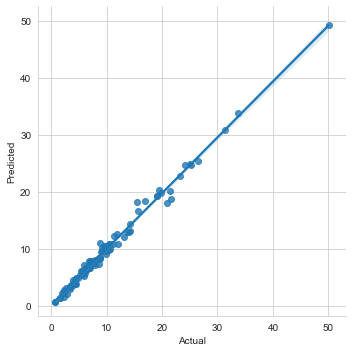

In [69]:
sns.set_style('whitegrid')
sns.lmplot(x ='Actual', y ='Predicted',  data = true_pred_all_train)

### Test

In [70]:
true_pred_all_test= pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_pred),
                            pd.DataFrame(y_test)- pd.DataFrame(y_pred)], axis=1)
true_pred_all_test.columns =['Actual', 'Predicted','Residuals']
true_pred_all_test.head(2)

,Actual,Predicted,Residuals
0,5.76,3.038875,2.721125
1,16.30,20.258305,-3.958305


In [71]:
# Write the prediction in an Excel sheet.
true_pred_all_test.to_excel("Model_1_Test_Output.xlsx",sheet_name='Test')  

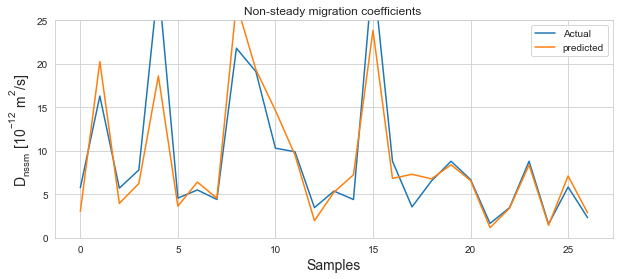

In [72]:
plt.figure(figsize=(10,4))
x_ax = range(len(y_test))
plt.plot(x_ax, true_pred_all_test.Actual, label="Actual")
plt.plot(x_ax, true_pred_all_test.Predicted, label="predicted")
plt.title("Non-steady migration coefficients ")
plt.xlabel("Samples",fontsize=14)
plt.ylabel("$\mathregular{D_{nssm}}$ [$\mathregular{10^{-12}}$ $\mathregular{m^{2}/s}$]",fontsize=14 )
plt.ylim([0, 25])
plt.legend()
plt.show()


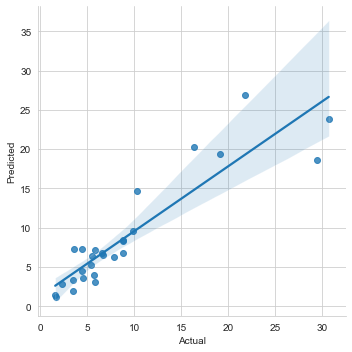

In [73]:
sns.set_style('whitegrid')
sns.lmplot(x ='Actual', y ='Predicted', data = true_pred_all_test)

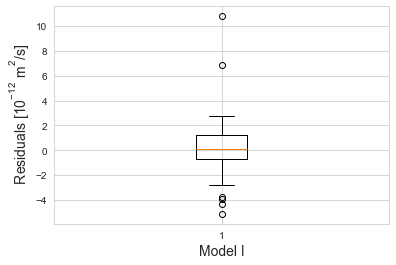

In [74]:
# Creating box plot
plt.boxplot(true_pred_all_test.Residuals)
#plt.title("Non-steady migration coefficients ")
plt.xlabel("Model I",fontsize=14)
plt.ylabel(" Residuals [$\mathregular{10^{-12}}$ $\mathregular{m^{2}/s}$]",fontsize=14)
# show plot
plt.show()

The models predict $D_{nssm}$ with high accuracy. The $D_{nssm}$ was evaluated at different ages (3, 7, 28, 56, 90, 91, 180 and 182). Let's examine the performance of the XGBoost model by considering $D_{nssm}$, which was only evaluated at 28 days of age.

### $D_{nssm}$at 28 days

In [75]:
df_all_ing_out_enc_FS_28 = df_all_ing_out_enc_FS[df_all_ing_out_enc_FS['Migration test age'] == 28]
df_all_ing_out_enc_FS_28.head(3)

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Migration test age,Cement type_CEM II/A-D,Cement type_CEM II/A-V,Cement type_CEM II/B-S,Cement type_CEM II/B-V,Cement type_CEM III/A,Cement type_CEM IV/A,Dnssm
0,0.55,350.0,0.0,0.0,0.0,699.988,1062.249,0.0,28,0,0,0,0,0,0,17.0
1,0.55,329.0,0.0,0.0,21.0,694.766,1059.600,0.0,28,1,0,0,0,0,0,14.2
2,0.55,297.5,0.0,52.5,0.0,692.233,1056.951,0.0,28,0,1,0,0,0,0,23.3


In [76]:
df_all_ing_out_enc_FS_28.shape

(86, 16)

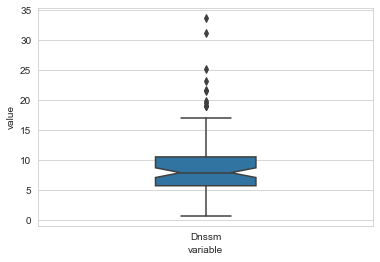

In [77]:
sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_out_enc_FS_28[cols4]), width= 0.3,notch= True)

In [78]:
# selected features after outliers removed for Dnssm examined at the age of 28 days

X = df_all_ing_out_enc_FS_28.iloc[:,0:-1].values
y = df_all_ing_out_enc_FS_28.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

#Prepare and train the model

model = XGBRegressor(n_jobs = 4)

## grid search to find the best model parameter

param_grid = {
        'n_estimators': [20, 50, 100, 500],
        'max_depth': [2, 4, 6, 8, 10],
        'gamma': [0.001, 0.001, 0.01],
        'learning_rate': [0.001, 0.01, 0.1, 0.3],
        'booster': ['gbtree']    
}

grid_search_model = GridSearchCV(model, param_grid = param_grid, cv=5, return_train_score=True)

grid_search_model.fit(X_train, y_train)

print(f'Best Score: {grid_search_model.best_score_}')
print(f'Best Param: {grid_search_model.best_params_}')

Best Score: 0.6175000995927994
Best Param: {'booster': 'gbtree', 'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}


In [79]:
## fitting the best model

best_model = grid_search_model.best_estimator_

best_model.fit(X_train, y_train)

print(f'Train Score: {best_model.score(X_train, y_train)}')
print(f'Test Score: {best_model.score(X_test, y_test)}')

Train Score: 0.999062617319339
Test Score: 0.8889039112595176


In [80]:
y_pred = best_model.predict(X_test)

In [81]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred)))

Mean Absolute Error (MAE): 1.239
Mean Squared Error (MSE):  5.307
RMSE: 2.304
R2 Score: 0.889


In [82]:
true_pred_all_28= pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_pred),
                            pd.DataFrame(y_test)- pd.DataFrame(y_pred)], axis=1)
true_pred_all_28.columns =['Actual', 'Predicted','Residuals']
true_pred_all_28.head(2)

,Actual,Predicted,Residuals
0,10.2,10.241113,-0.041113
1,8.8,5.988526,2.811474


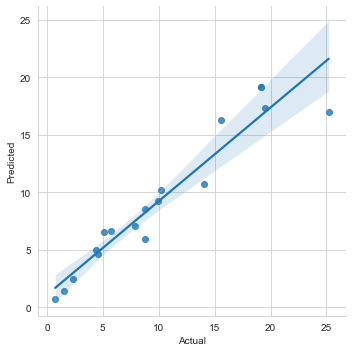

In [83]:
sns.set_style('whitegrid')
sns.lmplot(x ='Actual', y ='Predicted', data = true_pred_all_28)

### Residuals 

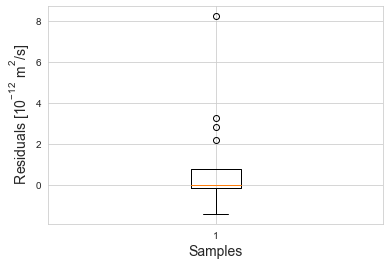

In [84]:
# Creating box plot
plt.boxplot(true_pred_all_28.Residuals)
#plt.title("Non-steady migration coefficients ")
plt.xlabel("Samples",fontsize=14)
plt.ylabel(" Residuals [$\mathregular{10^{-12}}$ $\mathregular{m^{2}/s}$]",fontsize=14)
# show plot
plt.show()

The statistical test measurements revealed that considering only the migration test date of 28 days does not improve the prediction accuracy of $D_{nssm}$.

# Senario 2: All mix proportions and fresh

## Preprocessing

In [85]:
# list the name of the DataFrame headings
df.columns

Index(['w/b', 'Water', 'Cement type', 'Cement', 'Slag', 'Fly ash',
       'Silica fume', 'Lime filler', 'Fine aggregate', 'Coarse aggregate',
       'Total aggregate', 'Plasticizer', 'Superplasticizer', 'Air entraining',
       'Comp. str. test age', 'Compressive strength', 'Air content', 'Spreed',
       'Slump', 'Fresh density', 'Dry  density', 'Migration test age', 'Dnssm',
       'Migration resistance'],
      dtype='object')

In [86]:
# Select features that represent mix components and fresh properties of concrete.

df_all_ing_fre=df.loc[:, ['w/b', 'Cement type', 'Cement','Slag', 'Fly ash','Silica fume','Fine aggregate',
                          'Coarse aggregate','Superplasticizer', 'Fresh density','Migration test age','Dnssm']]
df_all_ing_fre.head(2)

,w/b,Cement type,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Migration test age,Dnssm
0,0.45,NaN,400.0,0.0,0.0,0.0,640.0,960.0,0.0,NaN,120,2.85
1,0.45,NaN,380.0,0.0,0.0,20.0,640.0,960.0,0.0,NaN,120,1.75


In [87]:
df_all_ing_fre.shape

(843, 12)

### Handling of missed data

In [88]:
# Check number of nan
df_all_ing_fre.isnull().sum().sum()

1382

In [89]:
# Drop all rows with NaN values and reset index after drop
df_all_ing_fre = df_all_ing_fre.dropna().reset_index(drop=True)
df_all_ing_fre.head(2)

,w/b,Cement type,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Migration test age,Dnssm
0,0.5,CEM I,350.0,0.0,0.0,0.0,791.0,1043.0,0.0,2331.0,182,8.981
1,0.5,CEM I,174.0,174.0,0.0,0.0,788.0,1039.0,0.0,2350.0,182,7.405


In [90]:
# Sanity check
df_all_ing_fre.isnull().sum().sum() 

0

In [91]:
# check the size of a dataframe "df_all_ing_fre"
df_all_ing_fre.shape

(196, 12)

### Data exploration throgh visualization 

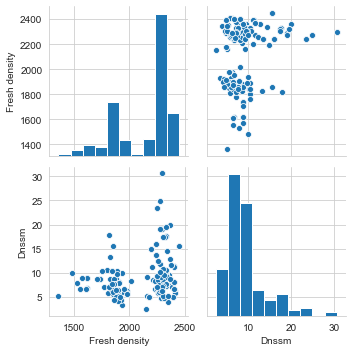

In [92]:
cols = ['Fresh density', 'Dnssm']
sns.pairplot(df_all_ing_fre[cols], height=2.5)
#sns.pairplot(df_all_ing_fre, height=2.5)
plt.tight_layout()
plt.show()

It is noticeable that the fresh density of the data set actually used is clustered into two groups. This is because the data uses lightweight and normal weight concrete. Although the fresh density of the concrete is separated in the database, there is no clear association to $D_{nssm}$.

In [93]:
df_all_ing_fre.describe()

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Migration test age,Dnssm
count,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,0.376221,330.161995,54.548534,33.927322,4.461815,726.390293,762.943521,0.238631,2141.791460,51.061224,9.340765
std,0.090400,245.864963,142.180962,131.451695,34.235477,264.256776,363.052522,0.487356,246.365404,83.410362,4.802819
min,0.215000,13.016485,0.000000,0.000000,0.000000,27.528026,0.000000,0.000000,1364.000000,3.000000,2.490000
25%,0.304297,226.631592,0.000000,0.000000,0.000000,670.998908,451.500000,0.000000,1900.000000,28.000000,6.300000
50%,0.380000,307.435487,0.000000,0.000000,0.000000,753.342398,936.265000,0.000000,2261.806976,28.000000,8.145876
75%,0.430000,440.000000,90.771292,0.000000,0.000000,829.363129,1066.711003,0.415345,2311.464211,28.000000,10.381000
max,0.650000,2384.971208,1284.443449,735.000000,468.500000,1574.100000,1187.146116,4.166667,2447.621146,365.000000,30.619803


### Outlier detection 

In [94]:
# Remove unnecessary  features 
df_all_ing_fre1 = df_all_ing_fre.drop(columns=['Cement type'])

In [95]:
df_all_ing_fre1['Mahal. Dis.'] = mahalanobis(x=df_all_ing_fre1, data=df_all_ing_fre1)
df_all_ing_fre1['Cement type']= df_all_ing_fre['Cement type']
df_all_ing_fre1.head(2)

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Migration test age,Dnssm,Mahal. Dis.,Cement type
0,0.5,350.0,0.0,0.0,0.0,791.0,1043.0,0.0,2331.0,182,8.981,7.632043,CEM I
1,0.5,174.0,174.0,0.0,0.0,788.0,1039.0,0.0,2350.0,182,7.405,15.020959,CEM I


In [96]:
# Remove extreme values for two degrees of freedom with a significance level of 0.01
df_all_ing_fre1 = df_all_ing_fre1[df_all_ing_fre1['Mahal. Dis.'] < chi2.ppf((1-0.01), df=2)]
df_all_ing_fre_out = df_all_ing_fre1.drop(columns=['Mahal. Dis.'])
df_all_ing_fre_out.head(2)

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Migration test age,Dnssm,Cement type
0,0.50,350.0,0.0,0.0,0.0,791.0,1043.0,0.0,2331.0,182,8.981,CEM I
8,0.45,350.0,0.0,0.0,0.0,993.0,451.5,0.0,1935.0,28,9.900,CEM I


In [97]:
df_all_ing_fre_out.shape

(131, 12)

In [98]:
cols1_fresh = ['w/b']
cols2_fresh = ['Cement', 'Fine aggregate', 'Coarse aggregate','Migration test age']
cols3_fresh = ['Superplasticizer']
cols4_fresh = ['Dnssm']

In [99]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_fre_out[cols1_fresh]), width= 0.3,notch= True)

In [100]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_fre_out[cols2_fresh]), width= 0.3,notch= True)

In [101]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_fre_out[cols3_fresh]), width= 0.3,notch= True)

In [102]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_fre_out[cols4_fresh]), width= 0.3,notch= True)

### Encoding Categorical Data 

In [103]:
# Examine  the data types of all features considered in the dataframe
df_all_ing_fre_out.dtypes

w/b                   float64
Cement                float64
Slag                  float64
Fly ash               float64
Silica fume           float64
Fine aggregate        float64
Coarse aggregate      float64
Superplasticizer      float64
Fresh density         float64
Migration test age      int64
Dnssm                 float64
Cement type            object
dtype: object

In [104]:
df_all_ing_fre_out['Cement type'].unique()

array(['CEM I', 'CEM II/A-S', 'CEM II/B-S', 'CEM II/B-V', 'CEM II/A-D'],
      dtype=object)

In [105]:
df_all_ing_fre_out["Cement type"] = df_all_ing_fre_out["Cement type"].astype('category')

In [106]:
# Sanity check
df_all_ing_fre_out.dtypes

w/b                    float64
Cement                 float64
Slag                   float64
Fly ash                float64
Silica fume            float64
Fine aggregate         float64
Coarse aggregate       float64
Superplasticizer       float64
Fresh density          float64
Migration test age       int64
Dnssm                  float64
Cement type           category
dtype: object

#### One-Hot Encoding


In [107]:
# Convert the values in the Cem_type_cat column into one-hot encoded vectors
df_all_ing_fre_out_enc=pd.get_dummies(df_all_ing_fre_out, columns=["Cement type"])

df_all_ing_fre_out_enc.head(2)

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Migration test age,Dnssm,Cement type_CEM I,Cement type_CEM II/A-D,Cement type_CEM II/A-S,Cement type_CEM II/B-S,Cement type_CEM II/B-V
0,0.50,350.0,0.0,0.0,0.0,791.0,1043.0,0.0,2331.0,182,8.981,1,0,0,0,0
8,0.45,350.0,0.0,0.0,0.0,993.0,451.5,0.0,1935.0,28,9.900,1,0,0,0,0


In [108]:
# examine shape of the new dataframe
df_all_ing_fre_out_enc.shape

(131, 16)

In [109]:
# Shift column 'Dnssm' to end position
end_column_fresh = df_all_ing_fre_out_enc.pop('Dnssm')

# Determine the postion
position_fresh = len(df_all_ing_fre_out_enc.columns)
  
# Insert column using insert(position,column_name,end_column) function
df_all_ing_fre_out_enc.insert(position_fresh, 'Dnssm', end_column_fresh)
df_all_ing_fre_out_enc.head(2)

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Migration test age,Cement type_CEM I,Cement type_CEM II/A-D,Cement type_CEM II/A-S,Cement type_CEM II/B-S,Cement type_CEM II/B-V,Dnssm
0,0.50,350.0,0.0,0.0,0.0,791.0,1043.0,0.0,2331.0,182,1,0,0,0,0,8.981
8,0.45,350.0,0.0,0.0,0.0,993.0,451.5,0.0,1935.0,28,1,0,0,0,0,9.900


In [110]:
df_all_ing_fre_out_enc.describe()

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Migration test age,Cement type_CEM I,Cement type_CEM II/A-D,Cement type_CEM II/A-S,Cement type_CEM II/B-S,Cement type_CEM II/B-V,Dnssm
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,0.347298,316.706145,52.588746,7.856146,2.213097,764.388132,872.500276,0.180569,2163.791252,28.503817,0.603053,0.015267,0.229008,0.045802,0.106870,8.569499
std,0.076858,101.705870,64.784760,22.709744,7.625310,138.523728,292.332146,0.324284,209.522211,14.094939,0.491143,0.123084,0.421807,0.209857,0.310134,3.511050
min,0.215000,186.000000,0.000000,0.000000,0.000000,517.000000,255.000000,0.000000,1534.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.400000
25%,0.286349,234.344186,0.000000,0.000000,0.000000,693.540135,573.500000,0.000000,1933.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.285258
50%,0.350000,271.720600,0.000000,0.000000,0.000000,751.681224,1037.047182,0.000000,2266.292145,28.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.600000
75%,0.400000,403.197174,106.789756,0.000000,0.000000,806.262655,1088.365592,0.200000,2303.454979,28.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.678612
max,0.540000,525.000000,186.882072,100.000000,36.000000,1073.000000,1187.146116,1.445026,2402.769450,182.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.423887


Text(0.5, 0, 'Random Forest Feature Importance')

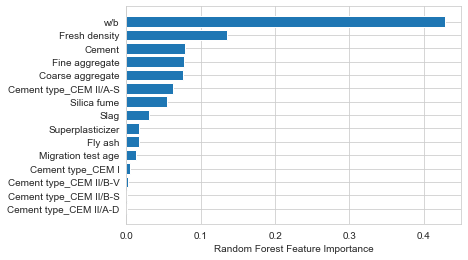

In [111]:
# load input and target features
X = df_all_ing_fre_out_enc.iloc[:,0:-1]
y = df_all_ing_fre_out_enc.iloc[:,-1]

# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

# Train the model using Sklearn RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(X_train, y_train)

# Determine feature importance values
rf.feature_importances_

# Let’s sort the plot the importances (chart will be easier to interpret than values).
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Model training

## XGBoost

In [112]:
# selected features after outlers removed 

X = df_all_ing_fre_out_enc.iloc[:,0:-1].values
y = df_all_ing_fre_out_enc.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

#Prepare and train the model

model = XGBRegressor()

## grid search to find the best model parameter

param_grid = {
        'n_estimators': [20, 50, 100, 300,500],
        'max_depth': [2, 4, 6, 8, 10],
        'gamma': [0.0001, 0.001, 0.01],
        'learning_rate': [0.001, 0.01, 0.1, 0.3],
        'booster': ['gbtree']
    }

grid_search_model = GridSearchCV(model, param_grid=param_grid, cv=5, return_train_score=True, n_jobs=-1)
grid_search_model.fit(X_train, y_train)

print(f'Best Score: {grid_search_model.best_score_}')
print(f'Best Param: {grid_search_model.best_params_}')

## fitting the best model

best_model = grid_search_model.best_estimator_
best_model.fit(X_train, y_train)

print(f'Train Score: {best_model.score(X_train, y_train)}')
print(f'Test Score: {best_model.score(X_test, y_test)}')

Best Score: 0.6846269763664814
Best Param: {'booster': 'gbtree', 'gamma': 0.001, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
Train Score: 0.9999613066353263
Test Score: 0.8875946166421382


###  XGBoost model evaluation

In [113]:
y_pred = best_model.predict(X_test)

In [114]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred)))

Mean Absolute Error (MAE): 0.500
Mean Squared Error (MSE):  1.243
RMSE: 1.115
R2 Score: 0.888


## Random Forest

In [115]:
start_time = datetime.now()

rf = RandomForestRegressor()

parameters_rf = {'bootstrap': [True],
                'max_depth': [80, 90, 100, 110],
                'max_features':['auto', 'sqrt', 'log2'],
                'min_samples_leaf': [3, 4, 5],
                'min_samples_split': [8, 10, 12],
                'n_estimators': [100, 200, 300, 1000]}

grid_search_rf = GridSearchCV(rf, param_grid = parameters_rf,cv = 5, n_jobs = -1, verbose = 2)
grid_search_rf.fit(X_train, y_train)

print(f'Best Score: {grid_search_rf.best_score_}')
print(f'Best Param: {grid_search_rf.best_params_}')

## fitting the best model

best_grid_rf = grid_search_rf.best_estimator_
best_grid_rf.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_rf.score(X_train, y_train)}')
print(f'Test Score: {best_grid_rf.score(X_test, y_test)}')
print('Random Forest: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 515.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 517.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 519.3min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 520.0min finished


Best Score: 0.4301346285597372
Best Param: {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
Train Score: 0.7827639357036481
Test Score: 0.6580067861654777
Random Forest: Duration: 8:40:03.551760


### Random Forest Model Evaluation

In [116]:
y_pred_rf = best_grid_rf.predict(X_test)

In [117]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_rf)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_rf)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_rf)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_rf)))

Mean Absolute Error (MAE): 1.319
Mean Squared Error (MSE):  3.782
RMSE: 1.945
R2 Score: 0.658


## Decision Tree

In [118]:
start_time = datetime.now()
dtr=DecisionTreeRegressor()

parameters_dtr={'splitter':['best','random'],
            'max_depth' : [2,3,4,5,6,7,8],
           'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
           'min_samples_split': [2,3,4,5,6,7,8,9,10], 
           'max_features':['auto','log2','sqrt',None],
           'max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90] }

grid_search_dtr = GridSearchCV(dtr,param_grid=parameters_dtr,cv=5,n_jobs = -1,verbose=3)
grid_search_dtr.fit(X_train, y_train)

print(f'Best Score: {grid_search_dtr.best_score_}')
print(f'Best Param: {grid_search_dtr.best_params_}')

## fitting the best model

best_grid_dtr = grid_search_dtr.best_estimator_
best_grid_dtr.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_dtr.score(X_train, y_train)}')
print(f'Test Score: {best_grid_dtr.score(X_test, y_test)}')
print('Decsion Tree: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 50400 candidates, totalling 252000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 15352 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 29688 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 48120 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 70648 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 97272 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 127992 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 162808 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 201720 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 244728 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 252000 out of 252000 | elapsed:  4.1min finished


Best Score: 0.7264560073420274
Best Param: {'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Train Score: 0.9216468702839372
Test Score: 0.7478063233774326
Decsion Tree: Duration: 0:04:09.365657


### Decision Tree Model Evaluation

In [119]:
y_pred_dtr = best_grid_dtr.predict(X_test)

In [120]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_dtr)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_dtr)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_dtr)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_dtr)))

Mean Absolute Error (MAE): 1.081
Mean Squared Error (MSE):  2.789
RMSE: 1.670
R2 Score: 0.748


## AdaBoost Regressor

In [121]:
start_time = datetime.now()

adbr = AdaBoostRegressor()
parameters_adbr={'learning_rate':[0.05,0.1,0.2,0.6,0.8,1],
                'n_estimators': [50,60,100],
                'loss' : ['linear', 'square', 'exponential']}

grid_search_adbr=GridSearchCV(adbr, param_grid=parameters_adbr,cv=5,n_jobs = -1, verbose=3)
grid_search_adbr.fit(X_train, y_train)

print(f'Best Score: {grid_search_adbr.best_score_}')
print(f'Best Param: {grid_search_adbr.best_params_}')

## fitting the best model

best_grid_adbr = grid_search_adbr.best_estimator_
best_grid_adbr.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_adbr.score(X_train, y_train)}')
print(f'Test Score: {best_grid_adbr.score(X_test, y_test)}')
print('AdaBoost Regressor: Duration: {}'.format(end_time - start_time))


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 263 out of 270 | elapsed:   11.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   11.8s finished


Best Score: 0.6785208249648755
Best Param: {'learning_rate': 0.8, 'loss': 'square', 'n_estimators': 100}
Train Score: 0.8625122390120532
Test Score: 0.7394966713542782
AdaBoost Regressor: Duration: 0:00:12.274539


### AdaBoost Model Evaluation

In [122]:
y_pred_adbr = best_grid_adbr.predict(X_test)

In [123]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_adbr)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_adbr)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_adbr)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_adbr)))

Mean Absolute Error (MAE): 1.321
Mean Squared Error (MSE):  2.881
RMSE: 1.697
R2 Score: 0.739


## Gradient Boosting

In [124]:
start_time = datetime.now()

gbr = GradientBoostingRegressor()

parameters_gbr = {'max_depth': [3,5,6,7],
              'max_features':['auto', 'sqrt', 'log2'],
              'min_samples_split': [2, 3, 10],
              'min_samples_leaf': [1, 3, 10],
            'learning_rate':[0.05,0.1,0.2],
            'n_estimators': [10,30,50,70]}

grid_search_gbr = GridSearchCV(gbr, param_grid=parameters_gbr,cv=5,n_jobs = -1, verbose=3)
grid_search_gbr.fit(X_train, y_train)

print(f'Best Score: {grid_search_gbr.best_score_}')
print(f'Best Param: {grid_search_gbr.best_params_}')

## fitting the best model

best_grid_gbr = grid_search_gbr.best_estimator_
best_grid_gbr.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_gbr.score(X_train, y_train)}')
print(f'Test Score: {best_grid_gbr.score(X_test, y_test)}')
print('Gradient Boosting Regressor: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 2104 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 3896 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  1.1min finished


Best Score: 0.7793810155176966
Best Param: {'learning_rate': 0.1, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 70}
Train Score: 0.9913787405380149
Test Score: 0.8569332048201788
Gradient Boosting Regressor: Duration: 0:01:05.308198


### Gradient Boosting Model Evaluation

In [125]:
y_pred_gbr = best_grid_gbr.predict(X_test)

In [126]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_gbr)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_gbr)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_gbr)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_gbr)))

Mean Absolute Error (MAE): 0.665
Mean Squared Error (MSE):  1.582
RMSE: 1.258
R2 Score: 0.857


## Bagging

In [127]:
start_time = datetime.now()

br = BaggingRegressor()

parameters_br = {'n_estimators': [50,100,200],
              'max_features':[1,2,4,6,8],
              'max_samples': [0.5,0.1],
            'bootstrap': [True, False],
         'bootstrap_features': [True, False]}


grid_search_br = GridSearchCV(br, param_grid=parameters_br,cv=5,n_jobs = -1, verbose=3)
grid_search_br.fit(X_train, y_train)

print(f'Best Score: {grid_search_br.best_score_}')
print(f'Best Param: {grid_search_br.best_params_}')

## fitting the best model

best_grid_br = grid_search_br.best_estimator_
best_grid_br.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_br.score(X_train, y_train)}')
print(f'Test Score: {best_grid_br.score(X_test, y_test)}')
print('Bagging Regressor: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   46.0s finished


Best Score: 0.589401919579181
Best Param: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 8, 'max_samples': 0.5, 'n_estimators': 50}
Train Score: 0.8989994030644417
Test Score: 0.6917144222950782
Bagging Regressor: Duration: 0:00:46.357166


### Bagging Model Evaluation

In [128]:
y_pred_br = best_grid_br.predict(X_test)

In [129]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_br)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_br)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_br)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_br)))

Mean Absolute Error (MAE): 1.305
Mean Squared Error (MSE):  3.409
RMSE: 1.846
R2 Score: 0.692


### XGBoost Model Output Visualization

### Training

In [130]:
y_pred_fre_train = best_model.predict(X_train)

In [131]:
true_pred_fre_train = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_pred_fre_train),
                            pd.DataFrame(y_train)- pd.DataFrame(y_pred_fre_train)], axis=1)
true_pred_fre_train.columns = ['Actual', 'Predicted','Residuals']
true_pred_fre_train.head(2)

,Actual,Predicted,Residuals
0,8.209001,8.207639,0.001362
1,6.700000,6.708951,-0.008951


Write the prediction in an Excel spreadsheet to visualize it with another tool.

In [1]:
# Write the prediction in an Excel sheet.
true_pred_fre_train.to_excel("Model_2_Train_Output.xlsx",sheet_name='Train') 

NameError: name 'true_pred_fre_train' is not defined

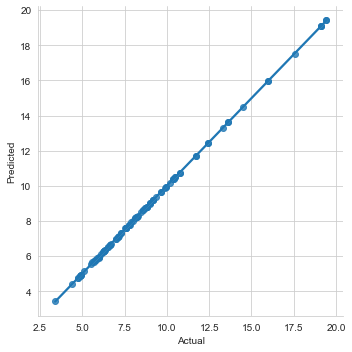

In [133]:
sns.set_style('whitegrid')
sns.lmplot(x ='Actual', y ='Predicted', data = true_pred_fre_train)

### Test

In [134]:
true_pred_fre_test= pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_pred),
                            pd.DataFrame(y_test)- pd.DataFrame(y_pred)], axis=1)
true_pred_fre_test.columns =['Actual', 'Predicted','Residuals']
true_pred_fre_test.head(2)

,Actual,Predicted,Residuals
0,6.54,6.096997,0.443003
1,9.50,11.112052,-1.612052


Write the prediction in an Excel spreadsheet to visualize it with another tool.

In [135]:
# Write the prediction in an Excel sheet.
true_pred_fre_test.to_excel("Model_2_Test_Output.xlsx",sheet_name='Test') 

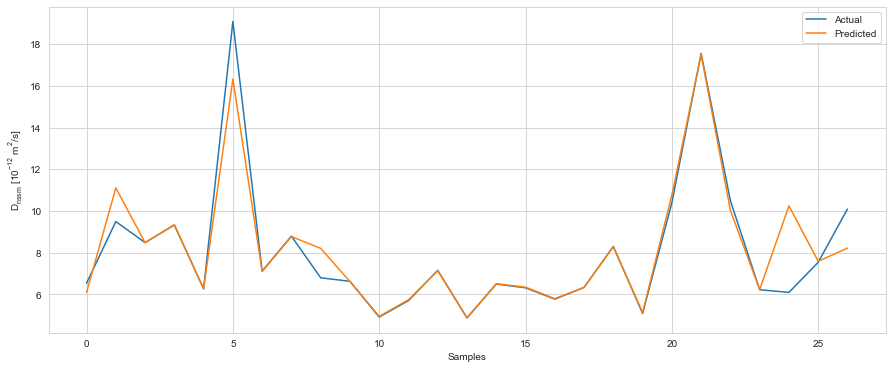

In [136]:
plt.figure(figsize=(15,6))
x_ax = range(len(y_test))
plt.plot(x_ax, true_pred_fre_test.Actual, label="Actual")
plt.plot(x_ax, true_pred_fre_test.Predicted, label="Predicted")
#plt.title("Non-steady migration coefficients ")
plt.xlabel("Samples")
plt.ylabel("$\mathregular{D_{nssm}}$ [$\mathregular{10^{-12}}$ $\mathregular{m^{2}/s}$]")
plt.legend()
plt.show()

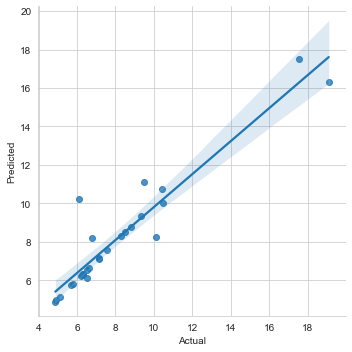

In [137]:
sns.set_style('whitegrid')
sns.lmplot(x ='Actual', y ='Predicted', data = true_pred_fre_test)

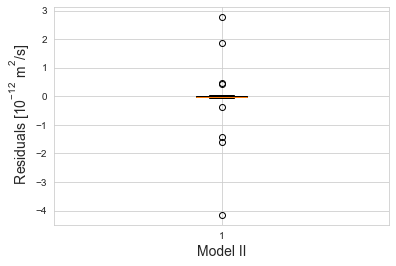

In [138]:
# Creating box plot
plt.boxplot(true_pred_fre_test.Residuals)
#plt.title("Non-steady migration coefficients ")
plt.xlabel("Model II",fontsize=14)
plt.ylabel(" Residuals [$\mathregular{10^{-12}}$ $\mathregular{m^{2}/s}$]",fontsize=14)
# show plot
plt.show()

# Senario 3: All mix proportions and hardened properties 

## Preprocessing

In [139]:
df.columns

Index(['w/b', 'Water', 'Cement type', 'Cement', 'Slag', 'Fly ash',
       'Silica fume', 'Lime filler', 'Fine aggregate', 'Coarse aggregate',
       'Total aggregate', 'Plasticizer', 'Superplasticizer', 'Air entraining',
       'Comp. str. test age', 'Compressive strength', 'Air content', 'Spreed',
       'Slump', 'Fresh density', 'Dry  density', 'Migration test age', 'Dnssm',
       'Migration resistance'],
      dtype='object')

In [140]:
# Select features that represent mix components and hardened properties of concrete.
df_all_ing_hard=df.loc[:, ['w/b', 'Cement type', 'Cement','Slag', 'Fly ash','Silica fume','Fine aggregate','Coarse aggregate',
                           'Superplasticizer', 'Comp. str. test age','Compressive strength','Migration test age','Dnssm']]

df_all_ing_hard.head()

,w/b,Cement type,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Comp. str. test age,Compressive strength,Migration test age,Dnssm
0,0.45,NaN,400.0,0.0,0.0,0.0,640.0,960.0,0.0,126.0,63.22,120,2.85
1,0.45,NaN,380.0,0.0,0.0,20.0,640.0,960.0,0.0,126.0,63.46,120,1.75
2,0.45,NaN,360.0,0.0,0.0,40.0,640.0,960.0,0.0,126.0,70.88,120,0.90
3,0.45,NaN,320.0,0.0,0.0,80.0,640.0,960.0,0.0,126.0,74.51,120,0.20
4,0.55,NaN,383.0,0.0,0.0,0.0,612.8,919.2,0.0,126.0,46.57,120,4.76


In [141]:
df_all_ing_hard.shape

(843, 13)

### Handling of missed data

In [142]:
# Check number of nan
df_all_ing_hard.isnull().sum().sum()

1541

In [143]:
# Drop all rows with NaN values and reset index after drop
df_all_ing_hard = df_all_ing_hard.dropna().reset_index(drop=True)
df_all_ing_hard.head(3)

,w/b,Cement type,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Comp. str. test age,Compressive strength,Migration test age,Dnssm
0,0.55,CEM I,350.0,0.0,0.0,0.0,699.988,1062.249,0.0,28.0,47.7,28,17.0
1,0.55,CEM II/A-D,329.0,0.0,0.0,21.0,694.766,1059.600,0.0,28.0,44.5,28,14.2
2,0.55,CEM II/A-V,297.5,0.0,52.5,0.0,692.233,1056.951,0.0,28.0,38.6,28,23.3


In [144]:
# Sanity check
df_all_ing_hard.isnull().sum().sum() 

0

In [145]:
# check the size of a dataframe "df_all_ing"
df_all_ing_hard.shape

(261, 13)

### Data exploration throgh visualization 

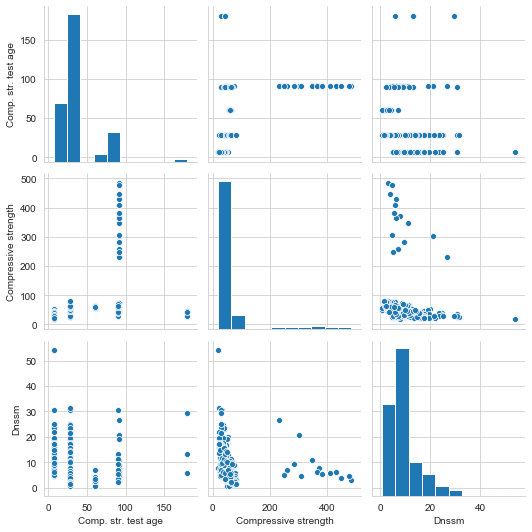

In [146]:
cols1 = ['Comp. str. test age','Compressive strength', 'Dnssm']
sns.pairplot(df_all_ing_hard[cols1], height=2.5)
#sns.pairplot(df_all_ing_fre, height=2.5)
plt.tight_layout()
plt.show()

It can be seen that the overall comprehensive strength is divided into two groups. This is due to the inclusion of normal weight and high performance concrete (HPC) in the dataset.

In [147]:
df_all_ing_hard.describe()

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Comp. str. test age,Compressive strength,Migration test age,Dnssm
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,0.394155,341.978742,47.917673,35.858449,6.493164,758.797846,835.172377,0.245946,33.191571,64.169487,53.076628,9.436278
std,0.096400,212.773294,126.618483,119.462397,31.401554,252.541329,331.314363,0.376294,29.078833,79.134412,73.718187,6.490366
min,0.215000,13.016485,0.000000,0.000000,0.000000,27.528026,0.000000,0.000000,7.000000,18.900000,3.000000,0.744000
25%,0.340000,250.955926,0.000000,0.000000,0.000000,670.995631,607.000000,0.000000,28.000000,34.000000,28.000000,5.730000
50%,0.380000,336.000000,0.000000,0.000000,0.000000,759.987094,972.973329,0.000000,28.000000,45.050362,28.000000,7.600000
75%,0.450000,440.000000,87.211634,0.000000,0.000000,866.000000,1072.050491,0.544444,28.000000,57.900000,28.000000,10.600000
max,0.651786,2384.971208,1284.443449,735.000000,468.500000,1574.100000,1240.000000,2.066116,180.000000,483.000000,365.000000,54.000000


In [148]:
cols1_hard = ['w/b']
cols2_hard = ['Cement', 'Fine aggregate', 'Coarse aggregate','Comp. str. test age','Compressive strength','Migration test age']
cols3_hard = ['Superplasticizer']
cols4_hard = ['Dnssm']

In [149]:
# sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_hard[cols1_hard]), width= 0.3,notch= True)

In [150]:
# sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_hard[cols2_hard]), width= 0.3,notch= True)

In [151]:
# sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_hard[cols3_hard]), width= 0.3,notch= True)

In [152]:
# sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_hard[cols4_hard]), width= 0.3,notch= True)

### Outlier detection 

In [153]:
# Remove unnecessary  features 
df_all_ing_hard1 = df_all_ing_hard.drop(columns=['Cement type'])

In [154]:
df_all_ing_hard1['Mahal. Dis.'] = mahalanobis(x=df_all_ing_hard1, data=df_all_ing_hard1)
df_all_ing_hard1['Cement type']= df_all_ing_hard['Cement type']
df_all_ing_hard1.head(2)

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Comp. str. test age,Compressive strength,Migration test age,Dnssm,Mahal. Dis.,Cement type
0,0.55,350.0,0.0,0.0,0.0,699.988,1062.249,0.0,28.0,47.7,28,17.0,4.791302,CEM I
1,0.55,329.0,0.0,0.0,21.0,694.766,1059.600,0.0,28.0,44.5,28,14.2,5.659501,CEM II/A-D


In [155]:

# Remove extreme values for two degrees of freedom with a significance level of 0.01
df_all_ing_hard1 = df_all_ing_hard1[df_all_ing_hard1['Mahal. Dis.'] < chi2.ppf((1-0.01), df=2)]
df_all_ing_hard_out = df_all_ing_hard1.drop(columns=['Mahal. Dis.'])
df_all_ing_hard_out.head(2)


,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Comp. str. test age,Compressive strength,Migration test age,Dnssm,Cement type
0,0.55,350.0,0.0,0.0,0.0,699.988,1062.249,0.0,28.0,47.7,28,17.0,CEM I
1,0.55,329.0,0.0,0.0,21.0,694.766,1059.600,0.0,28.0,44.5,28,14.2,CEM II/A-D


In [156]:
df_all_ing_hard_out.shape

(176, 13)

In [157]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_hard_out[cols1_hard]), width= 0.3,notch= True)

In [158]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_hard_out[cols2_hard]), width= 0.3,notch= True)

In [159]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_hard_out[cols3_hard]), width= 0.3,notch= True)

In [160]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_hard_out[cols4_hard]), width= 0.3,notch= True)

### Encoding Categorical Data 

In [161]:
# Examine  the data types of all features considered in the dataframe
df_all_ing_hard_out.dtypes

w/b                     float64
Cement                  float64
Slag                    float64
Fly ash                 float64
Silica fume             float64
Fine aggregate          float64
Coarse aggregate        float64
Superplasticizer        float64
Comp. str. test age     float64
Compressive strength    float64
Migration test age        int64
Dnssm                   float64
Cement type              object
dtype: object

In [162]:
df_all_ing_hard_out['Cement type'].unique()

array(['CEM I', 'CEM II/A-D', 'CEM II/A-V', 'CEM II/B-V', 'CEM III/A',
       'CEM II/A-S', 'CEM II/B-S', 'CEM IV/A'], dtype=object)

In [163]:
df_all_ing_hard_out["Cement type"] = df_all_ing_hard_out["Cement type"].astype('category')

In [164]:
# Sanity check
df_all_ing_hard_out.dtypes

w/b                      float64
Cement                   float64
Slag                     float64
Fly ash                  float64
Silica fume              float64
Fine aggregate           float64
Coarse aggregate         float64
Superplasticizer         float64
Comp. str. test age      float64
Compressive strength     float64
Migration test age         int64
Dnssm                    float64
Cement type             category
dtype: object

#### One-Hot Encoding

In [165]:
# Convert the values in the Cem_type_cat column into one-hot encoded vectors
df_all_ing_hard_out_enc=pd.get_dummies(df_all_ing_hard_out, columns=["Cement type"])
df_all_ing_hard_out_enc.head(2)

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Comp. str. test age,Compressive strength,Migration test age,Dnssm,Cement type_CEM I,Cement type_CEM II/A-D,Cement type_CEM II/A-S,Cement type_CEM II/A-V,Cement type_CEM II/B-S,Cement type_CEM II/B-V,Cement type_CEM III/A,Cement type_CEM IV/A
0,0.55,350.0,0.0,0.0,0.0,699.988,1062.249,0.0,28.0,47.7,28,17.0,1,0,0,0,0,0,0,0
1,0.55,329.0,0.0,0.0,21.0,694.766,1059.600,0.0,28.0,44.5,28,14.2,0,1,0,0,0,0,0,0


In [166]:
# examine shape of the new dataframe
df_all_ing_hard_out_enc.shape

(176, 20)

In [167]:
# Shift column 'Dnssm' to end position
end_column_hard= df_all_ing_hard_out_enc.pop('Dnssm')

# Determine the postion

position_hard = len(df_all_ing_hard_out_enc.columns)
  
# Insert column using insert(position,column_name,end_column) function
df_all_ing_hard_out_enc.insert(position_hard, 'Dnssm', end_column_hard)
df_all_ing_hard_out_enc.head(3)

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Comp. str. test age,Compressive strength,Migration test age,Cement type_CEM I,Cement type_CEM II/A-D,Cement type_CEM II/A-S,Cement type_CEM II/A-V,Cement type_CEM II/B-S,Cement type_CEM II/B-V,Cement type_CEM III/A,Cement type_CEM IV/A,Dnssm
0,0.55,350.0,0.0,0.0,0.0,699.988,1062.249,0.0,28.0,47.7,28,1,0,0,0,0,0,0,0,17.0
1,0.55,329.0,0.0,0.0,21.0,694.766,1059.600,0.0,28.0,44.5,28,0,1,0,0,0,0,0,0,14.2
2,0.55,297.5,0.0,52.5,0.0,692.233,1056.951,0.0,28.0,38.6,28,0,0,0,1,0,0,0,0,23.3


In [168]:
df_all_ing_hard_out_enc.describe()

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Comp. str. test age,Compressive strength,Migration test age,Cement type_CEM I,Cement type_CEM II/A-D,Cement type_CEM II/A-S,Cement type_CEM II/A-V,Cement type_CEM II/B-S,Cement type_CEM II/B-V,Cement type_CEM III/A,Cement type_CEM IV/A,Dnssm
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,0.370898,335.438280,39.142760,11.901450,4.888726,797.544890,894.641113,0.188381,24.818182,44.266734,32.664773,0.647727,0.017045,0.170455,0.005682,0.034091,0.096591,0.011364,0.017045,9.157929
std,0.085978,89.564669,60.391558,35.568865,12.866717,168.966433,266.234957,0.311679,16.228402,13.491417,17.954740,0.479041,0.129810,0.377104,0.075378,0.181980,0.296243,0.106295,0.129810,4.945901
min,0.215000,186.882072,0.000000,0.000000,0.000000,321.000000,266.350000,0.000000,7.000000,19.167433,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.690000
25%,0.304297,250.955926,0.000000,0.000000,0.000000,693.540135,731.000000,0.000000,7.000000,32.951782,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.100000
50%,0.360000,344.100324,0.000000,0.000000,0.000000,759.987094,1033.784162,0.000000,28.000000,43.430093,28.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.630000
75%,0.450000,400.000000,87.211634,0.000000,0.000000,915.250000,1087.475678,0.371667,28.000000,50.575000,28.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.501342
max,0.550000,525.000000,186.882072,192.000000,60.000000,1150.000000,1240.000000,1.100000,91.000000,80.000000,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.200000


# Model training

In [169]:
# selected features after outlers removed 

X = df_all_ing_hard_out_enc.iloc[:,0:-1].values
y = df_all_ing_hard_out_enc.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

#Prepare and train the model

model = XGBRegressor()

## grid search to find the best model parameter

param_grid = {
        'n_estimators': [20, 50, 100, 300,500],
        'max_depth': [2, 4, 6, 8, 10],
        'gamma': [0.0001, 0.001, 0.01],
        'learning_rate': [0.001, 0.01, 0.1, 0.3],
        'booster': ['gbtree']
    }

grid_search_model = GridSearchCV(model, param_grid=param_grid, cv=5, return_train_score=True, n_jobs=-1)
grid_search_model.fit(X_train, y_train)

print(f'Best Score: {grid_search_model.best_score_}')
print(f'Best Param: {grid_search_model.best_params_}')

## fitting the best model

best_model = grid_search_model.best_estimator_
best_model.fit(X_train, y_train)

print(f'Train Score: {best_model.score(X_train, y_train)}')
print(f'Test Score: {best_model.score(X_test, y_test)}')

Best Score: 0.5260225451729799
Best Param: {'booster': 'gbtree', 'gamma': 0.01, 'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 50}
Train Score: 0.9998672585395078
Test Score: 0.8654131941459263


### XGBoost model evaluation

In [170]:
y_pred = best_model.predict(X_test)

In [171]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred)))

Mean Absolute Error (MAE): 1.350
Mean Squared Error (MSE):  4.576
RMSE: 2.139
R2 Score: 0.865


## Random Forest

In [172]:
start_time = datetime.now()

rf = RandomForestRegressor()

parameters_rf = {'bootstrap': [True],
                'max_depth': [80, 90, 100, 110],
                'max_features':['auto', 'sqrt', 'log2'],
                'min_samples_leaf': [3, 4, 5],
                'min_samples_split': [8, 10, 12],
                'n_estimators': [100, 200, 300, 1000]}

grid_search_rf = GridSearchCV(rf, param_grid = parameters_rf,cv = 5, n_jobs = -1, verbose = 2)
grid_search_rf.fit(X_train, y_train)

print(f'Best Score: {grid_search_rf.best_score_}')
print(f'Best Param: {grid_search_rf.best_params_}')

## fitting the best model

best_grid_rf = grid_search_rf.best_estimator_
best_grid_rf.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_rf.score(X_train, y_train)}')
print(f'Test Score: {best_grid_rf.score(X_test, y_test)}')
print('Random Forest: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  7.9min finished


Best Score: 0.31102385496610807
Best Param: {'bootstrap': True, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
Train Score: 0.7745630234896475
Test Score: 0.6176261704931434
Random Forest: Duration: 0:07:57.255257


### Random Forest Model Evaluation

In [173]:
y_pred_rf = best_grid_rf.predict(X_test)

In [174]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_rf)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_rf)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_rf)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_rf)))

Mean Absolute Error (MAE): 2.683
Mean Squared Error (MSE):  13.002
RMSE: 3.606
R2 Score: 0.618


## Decision Tree

In [175]:
start_time = datetime.now()
dtr=DecisionTreeRegressor()

parameters_dtr={'splitter':['best','random'],
            'max_depth' : [2,3,4,5,6,7,8],
           'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
           'min_samples_split': [2,3,4,5,6,7,8,9,10], 
           'max_features':['auto','log2','sqrt',None],
           'max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90] }

grid_search_dtr = GridSearchCV(dtr,param_grid=parameters_dtr,cv=5,n_jobs = -1,verbose=3)
grid_search_dtr.fit(X_train, y_train)

print(f'Best Score: {grid_search_dtr.best_score_}')
print(f'Best Param: {grid_search_dtr.best_params_}')

## fitting the best model

best_grid_dtr = grid_search_dtr.best_estimator_
best_grid_dtr.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_dtr.score(X_train, y_train)}')
print(f'Test Score: {best_grid_dtr.score(X_test, y_test)}')
print('Decsion Tree: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 50400 candidates, totalling 252000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 15352 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 29688 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 48120 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 70648 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 97272 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 130912 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 174432 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 220752 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 252000 out of 252000 | elapsed:  4.7min finished


Best Score: 0.4968624571461711
Best Param: {'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': 20, 'min_samples_leaf': 2, 'min_samples_split': 3, 'splitter': 'random'}
Train Score: 0.7863814582986073
Test Score: 0.5743594198304788
Decsion Tree: Duration: 0:04:44.735384


### Decision Tree Model Evaluation

In [176]:
y_pred_dtr = best_grid_dtr.predict(X_test)

In [177]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_dtr)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_dtr)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_dtr)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_dtr)))

Mean Absolute Error (MAE): 2.619
Mean Squared Error (MSE):  14.473
RMSE: 3.804
R2 Score: 0.574


## AdaBoost Regressor

In [178]:
start_time = datetime.now()

adbr = AdaBoostRegressor()
parameters_adbr={'learning_rate':[0.05,0.1,0.2,0.6,0.8,1],
                'n_estimators': [50,60,100],
                'loss' : ['linear', 'square', 'exponential']}

grid_search_adbr=GridSearchCV(adbr, param_grid=parameters_adbr,cv=5,n_jobs = -1, verbose=3)
grid_search_adbr.fit(X_train, y_train)

print(f'Best Score: {grid_search_adbr.best_score_}')
print(f'Best Param: {grid_search_adbr.best_params_}')

## fitting the best model

best_grid_adbr = grid_search_adbr.best_estimator_
best_grid_adbr.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_adbr.score(X_train, y_train)}')
print(f'Test Score: {best_grid_adbr.score(X_test, y_test)}')
print('AdaBoost Regressor: Duration: {}'.format(end_time - start_time))


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 263 out of 270 | elapsed:   12.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   12.8s finished


Best Score: 0.3500540111201599
Best Param: {'learning_rate': 0.6, 'loss': 'square', 'n_estimators': 100}
Train Score: 0.853193796840566
Test Score: 0.7805949536314972
AdaBoost Regressor: Duration: 0:00:13.281461


### AdaBoost Model Evaluation

In [179]:
y_pred_adbr = best_grid_adbr.predict(X_test)

In [180]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_adbr)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_adbr)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_adbr)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_adbr)))

Mean Absolute Error (MAE): 2.230
Mean Squared Error (MSE):  7.461
RMSE: 2.731
R2 Score: 0.781


## Gradient Boosting

In [181]:
start_time = datetime.now()

gbr = GradientBoostingRegressor()

parameters_gbr = {'max_depth': [3,5,6,7],
              'max_features':['auto', 'sqrt', 'log2'],
              'min_samples_split': [2, 3, 10],
              'min_samples_leaf': [1, 3, 10],
            'learning_rate':[0.05,0.1,0.2],
            'n_estimators': [10,30,50,70]}

grid_search_gbr = GridSearchCV(gbr, param_grid=parameters_gbr,cv=5,n_jobs = -1, verbose=3)
grid_search_gbr.fit(X_train, y_train)

print(f'Best Score: {grid_search_gbr.best_score_}')
print(f'Best Param: {grid_search_gbr.best_params_}')

## fitting the best model

best_grid_gbr = grid_search_gbr.best_estimator_
best_grid_gbr.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_gbr.score(X_train, y_train)}')
print(f'Test Score: {best_grid_gbr.score(X_test, y_test)}')
print('Gradient Boosting Regressor: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1976 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 4536 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:  1.0min


Best Score: 0.5079117131360685
Best Param: {'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 70}
Train Score: 0.9827325394083628
Test Score: 0.9069078473870835
Gradient Boosting Regressor: Duration: 0:01:03.758515


[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  1.1min finished


### Gradient Boosting Model Evaluation

In [182]:
y_pred_gbr = best_grid_gbr.predict(X_test)

In [183]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_gbr)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_gbr)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_gbr)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_gbr)))

Mean Absolute Error (MAE): 1.212
Mean Squared Error (MSE):  3.165
RMSE: 1.779
R2 Score: 0.907


## Bagging

In [184]:
start_time = datetime.now()

br = BaggingRegressor()

parameters_br = {'n_estimators': [50,100,200],
              'max_features':[1,2,4,6,8],
              'max_samples': [0.5,0.1],
            'bootstrap': [True, False],
         'bootstrap_features': [True, False]}


grid_search_br = GridSearchCV(br, param_grid=parameters_br,cv=5,n_jobs = -1, verbose=3)
grid_search_br.fit(X_train, y_train)

print(f'Best Score: {grid_search_br.best_score_}')
print(f'Best Param: {grid_search_br.best_params_}')

## fitting the best model

best_grid_br = grid_search_br.best_estimator_
best_grid_br.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_br.score(X_train, y_train)}')
print(f'Test Score: {best_grid_br.score(X_test, y_test)}')
print('Bagging Regressor: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   55.3s finished


Best Score: 0.32651380853621026
Best Param: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 8, 'max_samples': 0.5, 'n_estimators': 100}
Train Score: 0.8676764683587914
Test Score: 0.6383596477155604
Bagging Regressor: Duration: 0:00:56.289080


### Bagging Model Evaluation

In [185]:
y_pred_br = best_grid_br.predict(X_test)

In [186]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_br)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_br)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_br)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_br)))

Mean Absolute Error (MAE): 2.681
Mean Squared Error (MSE):  12.297
RMSE: 3.507
R2 Score: 0.638


### XGBoost Output Visualization

### Training

In [187]:
y_pred_train_hard = best_model.predict(X_train)

In [188]:
true_pred_all_train_hard= pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_pred_train_hard),
                            pd.DataFrame(y_train)- pd.DataFrame(y_pred_train_hard)], axis=1)
true_pred_all_train_hard.columns =['Actual', 'Predicted','Residuals']
true_pred_all_train_hard.head(2)

,Actual,Predicted,Residuals
0,8.600000,8.603870,-0.003870
1,9.678612,9.574224,0.104388


Write the prediction in an Excel spreadsheet to visualize it with another tool.

In [189]:
# Write the prediction in an Excel sheet.
true_pred_all_train_hard.to_excel("Model_3_Train_Output.xlsx",sheet_name='Train') 

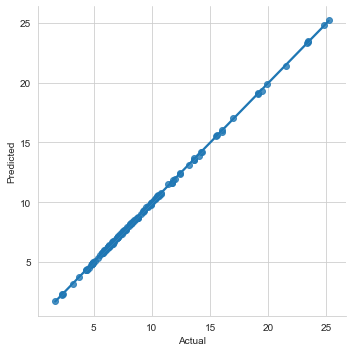

In [190]:
sns.set_style('whitegrid')
sns.lmplot(x ='Actual', y ='Predicted', data = true_pred_all_train_hard)

### Test 

In [191]:
true_pred_all_hard_test= pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_pred),
                            pd.DataFrame(y_test)- pd.DataFrame(y_pred)], axis=1)
true_pred_all_hard_test.columns =['Actual', 'Predicted','Residuals']
true_pred_all_hard_test.head(3)

,Actual,Predicted,Residuals
0,2.630000,4.835962,-2.205962
1,5.600000,5.942503,-0.342503
2,9.021996,8.645005,0.376991


Write the prediction in an Excel spreadsheet to visualize it with another tool.

In [192]:
# Write the prediction in an Excel sheet.
true_pred_all_hard_test.to_excel("Model_3_Test_Output.xlsx",sheet_name='Test') 

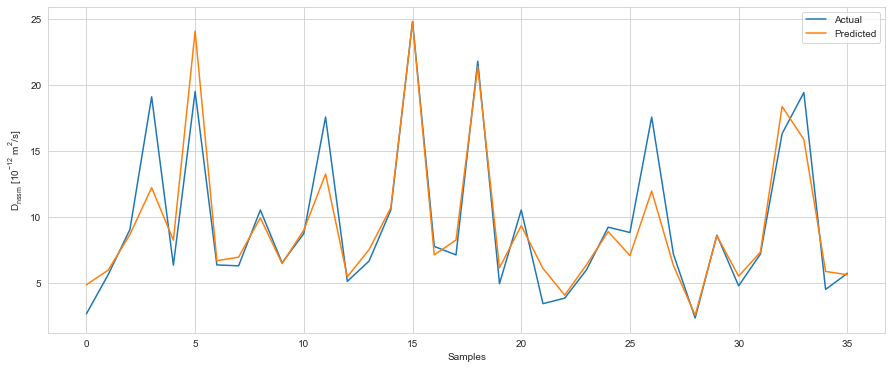

In [193]:
plt.figure(figsize=(15,6))
x_ax = range(len(y_test))
plt.plot(x_ax, true_pred_all_hard_test.Actual, label="Actual")
plt.plot(x_ax, true_pred_all_hard_test.Predicted, label="Predicted")
#plt.title("Non-steady migration coefficients ")
plt.xlabel("Samples")
plt.ylabel("$\mathregular{D_{nssm}}$ [$\mathregular{10^{-12}}$ $\mathregular{m^{2}/s}$]")
plt.legend()
plt.show()

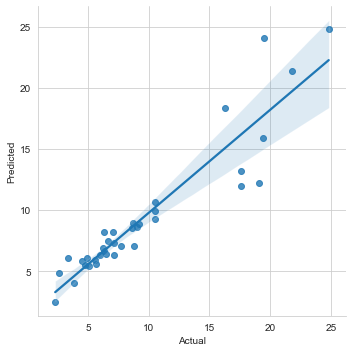

In [194]:
sns.set_style('whitegrid')
sns.lmplot(x ='Actual', y ='Predicted', data = true_pred_all_hard_test)

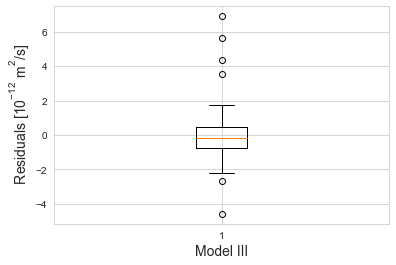

In [195]:
# Creating box plot
plt.boxplot(true_pred_all_hard_test.Residuals)
#plt.title("Non-steady migration coefficients ")
plt.xlabel("Model III",fontsize=14)
plt.ylabel(" Residuals [$\mathregular{10^{-12}}$ $\mathregular{m^{2}/s}$]",fontsize=14)
# show plot
plt.show()

# Senario 4: All mix proportions as well as fresh and hardened properties

## Preprocessing


In [196]:
df.columns

Index(['w/b', 'Water', 'Cement type', 'Cement', 'Slag', 'Fly ash',
       'Silica fume', 'Lime filler', 'Fine aggregate', 'Coarse aggregate',
       'Total aggregate', 'Plasticizer', 'Superplasticizer', 'Air entraining',
       'Comp. str. test age', 'Compressive strength', 'Air content', 'Spreed',
       'Slump', 'Fresh density', 'Dry  density', 'Migration test age', 'Dnssm',
       'Migration resistance'],
      dtype='object')

In [197]:
# Select features that represent the mix components and the fresh and hardened properties of concrete.
df_all_ing_fre_hard=df.loc[:, ['w/b', 'Cement type', 'Cement','Slag', 'Fly ash', 'Silica fume','Fine aggregate','Coarse aggregate',
                           'Superplasticizer', 'Fresh density','Comp. str. test age', 'Compressive strength', 
                            'Migration test age','Dnssm']]

df_all_ing_fre_hard.head()

,w/b,Cement type,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Comp. str. test age,Compressive strength,Migration test age,Dnssm
0,0.45,NaN,400.0,0.0,0.0,0.0,640.0,960.0,0.0,NaN,126.0,63.22,120,2.85
1,0.45,NaN,380.0,0.0,0.0,20.0,640.0,960.0,0.0,NaN,126.0,63.46,120,1.75
2,0.45,NaN,360.0,0.0,0.0,40.0,640.0,960.0,0.0,NaN,126.0,70.88,120,0.90
3,0.45,NaN,320.0,0.0,0.0,80.0,640.0,960.0,0.0,NaN,126.0,74.51,120,0.20
4,0.55,NaN,383.0,0.0,0.0,0.0,612.8,919.2,0.0,NaN,126.0,46.57,120,4.76


In [198]:
df_all_ing_fre_hard.shape

(843, 14)

### Handling of missed data

In [199]:
# Check number of nan
df_all_ing_fre_hard.isnull().sum().sum()

1988

In [200]:
# Drop all rows with NaN values and reset index after drop
df_all_ing_fre_hard = df_all_ing_fre_hard.dropna().reset_index(drop=True)
df_all_ing_fre_hard.head(3)

,w/b,Cement type,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Comp. str. test age,Compressive strength,Migration test age,Dnssm
0,0.4,CEM I,520.6,312.3,442.5,468.5,1574.1,0.0,0.4,2210.0,28.0,60.4,28,8.56
1,0.4,CEM I,312.3,208.2,0.0,0.0,1574.1,0.0,0.2,2160.0,28.0,51.9,28,5.13
2,0.4,CEM I,442.5,0.0,78.1,0.0,1574.1,0.0,0.4,2200.0,28.0,54.0,28,11.15


In [201]:
# Sanity check
df_all_ing_fre_hard.isnull().sum().sum() 

0

In [202]:
# check the size of a dataframe "df_all_ing"
df_all_ing_fre_hard.shape

(176, 14)

### Data exploration 

In [203]:
df_all_ing_fre_hard.describe()

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Comp. str. test age,Compressive strength,Migration test age,Dnssm
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,0.372091,344.975858,56.696095,37.782700,4.968839,729.911917,772.755285,0.149918,2154.676853,23.585227,41.986333,50.181818,9.420107
std,0.091922,253.847813,147.020596,138.231164,36.103806,273.957505,369.023534,0.257937,233.502153,16.891371,12.425708,85.505094,4.918194
min,0.215000,13.016485,0.000000,0.000000,0.000000,27.528026,0.000000,0.000000,1483.000000,7.000000,19.167433,3.000000,2.490000
25%,0.301211,249.176096,0.000000,0.000000,0.000000,670.998908,451.500000,0.000000,1905.000000,7.000000,32.410543,28.000000,6.300000
50%,0.360186,334.607901,0.000000,0.000000,0.000000,752.511811,999.967406,0.000000,2264.049560,28.000000,40.787831,28.000000,8.072938
75%,0.430000,450.000000,101.450268,0.000000,0.000000,846.000000,1072.792086,0.216624,2307.619780,28.000000,48.600000,28.000000,10.400000
max,0.650000,2384.971208,1284.443449,735.000000,468.500000,1574.100000,1187.146116,0.828000,2447.621146,91.000000,76.200000,365.000000,30.619803


In [204]:
cols1_fre_hard = ['w/b']
cols2_fre_hard = ['Cement', 'Fine aggregate', 'Coarse aggregate', 'Comp. str. test age','Compressive strength','Migration test age 	']
cols3_fre_hard = ['Superplasticizer']
cols4_fre_hard = ['Dnssm']

In [205]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_fre_hard[cols1_fre_hard]), width= 0.3,notch= True)

In [206]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_fre_hard[cols2_fre_hard]), width= 0.3,notch= True)

In [207]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_fre_hard[cols3_fre_hard]), width= 0.3,notch= True)

In [208]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_fre_hard[cols4_fre_hard]), width= 0.3,notch= True)

### Outlier detection 

In [209]:
# Remove unnecessary features 

df_all_ing_fre_hard1 = df_all_ing_fre_hard.drop(columns=['Cement type'])

In [210]:
df_all_ing_fre_hard1['Mahal. Dis.'] = mahalanobis(x=df_all_ing_fre_hard1, data=df_all_ing_fre_hard1)
df_all_ing_fre_hard1['Cement type']= df_all_ing_fre_hard['Cement type']
df_all_ing_fre_hard1.head(2)

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Comp. str. test age,Compressive strength,Migration test age,Dnssm,Mahal. Dis.,Cement type
0,0.4,520.6,312.3,442.5,468.5,1574.1,0.0,0.4,2210.0,28.0,60.4,28,8.56,165.617352,CEM I
1,0.4,312.3,208.2,0.0,0.0,1574.1,0.0,0.2,2160.0,28.0,51.9,28,5.13,37.212740,CEM I


In [211]:
# Remove extreme values for two degrees of freedom with a significance level of 0.01
df_all_ing_fre_hard1 = df_all_ing_fre_hard1[df_all_ing_fre_hard1['Mahal. Dis.'] < chi2.ppf((1-0.01), df=2)]
df_all_ing_fre_hard_out = df_all_ing_fre_hard1.drop(columns=['Mahal. Dis.'])
df_all_ing_fre_hard_out.head(2)

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Comp. str. test age,Compressive strength,Migration test age,Dnssm,Cement type
6,0.40,460.0,0.0,0.0,0.0,991.0,451.5,0.2,1905.0,28.0,54.6,28,8.0,CEM I
7,0.33,450.0,0.0,0.0,0.0,1033.0,451.5,0.7,1982.0,28.0,64.6,3,6.2,CEM I


In [212]:
df_all_ing_fre_hard_out.shape

(91, 14)

In [213]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_fre_hard_out[cols1_fresh]), width= 0.3,notch= True)

In [214]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_fre_hard_out[cols2_fresh]), width= 0.3,notch= True)

In [215]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_fre_hard_out[cols3_fresh]), width= 0.3,notch= True)

In [216]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_all_ing_fre_hard_out[cols4_fresh]), width= 0.3,notch= True)

### Encoding Categorical Data 

In [217]:
# Examine  the data types of all features considered in the dataframe
df_all_ing_fre_hard_out.dtypes

w/b                     float64
Cement                  float64
Slag                    float64
Fly ash                 float64
Silica fume             float64
Fine aggregate          float64
Coarse aggregate        float64
Superplasticizer        float64
Fresh density           float64
Comp. str. test age     float64
Compressive strength    float64
Migration test age        int64
Dnssm                   float64
Cement type              object
dtype: object

In [218]:
df_all_ing_fre_hard_out['Cement type'].unique()

array(['CEM I', 'CEM II/A-S', 'CEM II/B-S', 'CEM II/B-V', 'CEM II/A-D'],
      dtype=object)

In [219]:
df_all_ing_fre_hard_out["Cement type"] = df_all_ing_fre_hard_out["Cement type"].astype('category')

In [220]:
# Sanity check
df_all_ing_fre_hard_out.dtypes

w/b                      float64
Cement                   float64
Slag                     float64
Fly ash                  float64
Silica fume              float64
Fine aggregate           float64
Coarse aggregate         float64
Superplasticizer         float64
Fresh density            float64
Comp. str. test age      float64
Compressive strength     float64
Migration test age         int64
Dnssm                    float64
Cement type             category
dtype: object

#### One-Hot Encoding

In [221]:
# Convert the values in the Cem_type_cat column into one-hot encoded vectors
df_all_ing_fre_hard_out_enc=pd.get_dummies(df_all_ing_fre_hard_out, columns=["Cement type"])

df_all_ing_fre_hard_out_enc.head(2)

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Comp. str. test age,Compressive strength,Migration test age,Dnssm,Cement type_CEM I,Cement type_CEM II/A-D,Cement type_CEM II/A-S,Cement type_CEM II/B-S,Cement type_CEM II/B-V
6,0.40,460.0,0.0,0.0,0.0,991.0,451.5,0.2,1905.0,28.0,54.6,28,8.0,1,0,0,0,0
7,0.33,450.0,0.0,0.0,0.0,1033.0,451.5,0.7,1982.0,28.0,64.6,3,6.2,1,0,0,0,0


In [222]:
# examine shape of the new dataframe
df_all_ing_fre_hard_out_enc.shape

(91, 18)

In [223]:
# Shift column 'Dnssm' to end position
end_column_fresh_hard = df_all_ing_fre_hard_out_enc.pop('Dnssm')

# Determine the postion
position_all_fre_hard = len(df_all_ing_fre_hard_out_enc.columns)
  
# Insert column using insert(position,column_name,end_column) function
df_all_ing_fre_hard_out_enc.insert(position_all_fre_hard, 'Dnssm', end_column_fresh_hard)
df_all_ing_fre_hard_out_enc.head(3)

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Comp. str. test age,Compressive strength,Migration test age,Cement type_CEM I,Cement type_CEM II/A-D,Cement type_CEM II/A-S,Cement type_CEM II/B-S,Cement type_CEM II/B-V,Dnssm
6,0.40,460.0,0.0,0.0,0.0,991.0,451.5,0.2,1905.0,28.0,54.6,28,1,0,0,0,0,8.0
7,0.33,450.0,0.0,0.0,0.0,1033.0,451.5,0.7,1982.0,28.0,64.6,3,1,0,0,0,0,6.2
8,0.34,450.0,0.0,0.0,0.0,1033.0,451.5,0.7,1982.0,28.0,64.6,7,1,0,0,0,0,5.8


In [224]:
df_all_ing_fre_hard_out_enc.describe()

,w/b,Cement,Slag,Fly ash,Silica fume,Fine aggregate,Coarse aggregate,Superplasticizer,Fresh density,Comp. str. test age,Compressive strength,Migration test age,Cement type_CEM I,Cement type_CEM II/A-D,Cement type_CEM II/A-S,Cement type_CEM II/B-S,Cement type_CEM II/B-V,Dnssm
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,0.324807,301.056614,70.065293,8.864577,1.238709,775.471614,924.474325,0.116078,2200.614385,20.153846,40.220768,27.010989,0.527473,0.021978,0.285714,0.054945,0.109890,8.161780
std,0.063923,91.394717,64.281411,23.916673,5.398959,124.657062,271.544858,0.245342,182.081610,10.215373,9.586697,4.776085,0.502011,0.147424,0.454257,0.229135,0.314485,2.981836
min,0.215000,186.882072,0.000000,0.000000,0.000000,517.000000,372.820000,0.000000,1620.000000,7.000000,21.787442,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.753202
25%,0.277240,234.640824,0.000000,0.000000,0.000000,701.291588,913.942325,0.000000,2230.891342,7.000000,32.708741,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.249198
50%,0.317311,261.041625,83.651975,0.000000,0.000000,753.461053,1056.032028,0.000000,2274.621746,28.000000,40.383594,28.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.544869
75%,0.360372,363.381807,121.621666,0.000000,0.000000,809.525675,1089.255507,0.000000,2303.454979,28.000000,46.500000,28.000000,1.000000,0.000000,1.000000,0.000000,0.000000,9.204516
max,0.450000,500.000000,186.882072,100.000000,29.663821,1043.000000,1187.146116,0.700000,2402.769450,28.000000,64.600000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.423887


# Model Training


In [225]:
# selected features after outlers removed 

X = df_all_ing_fre_hard_out_enc.iloc[:,0:-1].values
y = df_all_ing_fre_hard_out_enc.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

#Prepare and train the model

model = XGBRegressor()

## grid search to find the best model parameter

param_grid = {
        'n_estimators': [20, 50, 100, 300,500],
        'max_depth': [2, 4, 6, 8, 10],
        'gamma': [0.0001, 0.001, 0.01],
        'learning_rate': [0.001, 0.01, 0.1, 0.3],
        'booster': ['gbtree']
    }

grid_search_model = GridSearchCV(model, param_grid=param_grid, cv=5, return_train_score=True, n_jobs=-1)
grid_search_model.fit(X_train, y_train)

print(f'Best Score: {grid_search_model.best_score_}')
print(f'Best Param: {grid_search_model.best_params_}')

## fitting the best model

best_model = grid_search_model.best_estimator_
best_model.fit(X_train, y_train)

print(f'Train Score: {best_model.score(X_train, y_train)}')
print(f'Test Score: {best_model.score(X_test, y_test)}')

Best Score: 0.3525119471318308
Best Param: {'booster': 'gbtree', 'gamma': 0.001, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
Train Score: 0.9999008851935374
Test Score: 0.9637344387377196


### XGBoost model evaluation

In [226]:
y_pred = best_model.predict(X_test)

In [227]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred)))

Mean Absolute Error (MAE): 0.416
Mean Squared Error (MSE):  0.307
RMSE: 0.554
R2 Score: 0.964


## Random Forest

In [228]:
start_time = datetime.now()

rf = RandomForestRegressor()

parameters_rf = {'bootstrap': [True],
                'max_depth': [80, 90, 100, 110],
                'max_features':['auto', 'sqrt', 'log2'],
                'min_samples_leaf': [3, 4, 5],
                'min_samples_split': [8, 10, 12],
                'n_estimators': [100, 200, 300, 1000]}

grid_search_rf = GridSearchCV(rf, param_grid = parameters_rf,cv = 5, n_jobs = -1, verbose = 2)
grid_search_rf.fit(X_train, y_train)

print(f'Best Score: {grid_search_rf.best_score_}')
print(f'Best Param: {grid_search_rf.best_params_}')

## fitting the best model

best_grid_rf = grid_search_rf.best_estimator_
best_grid_rf.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_rf.score(X_train, y_train)}')
print(f'Test Score: {best_grid_rf.score(X_test, y_test)}')
print('Random Forest: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  8.1min finished


Best Score: -0.011174162951706123
Best Param: {'bootstrap': True, 'max_depth': 90, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
Train Score: 0.6124492834218346
Test Score: 0.6107794245273117
Random Forest: Duration: 0:08:05.372999


### Random Forest Model Evaluation

In [229]:
y_pred_rf = best_grid_rf.predict(X_test)

In [230]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_rf)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_rf)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_rf)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_rf)))

Mean Absolute Error (MAE): 1.240
Mean Squared Error (MSE):  3.299
RMSE: 1.816
R2 Score: 0.611


## Decision Tree

In [231]:
start_time = datetime.now()
dtr=DecisionTreeRegressor()

parameters_dtr={'splitter':['best','random'],
            'max_depth' : [2,3,4,5,6,7,8],
           'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
           'min_samples_split': [2,3,4,5,6,7,8,9,10], 
           'max_features':['auto','log2','sqrt',None],
           'max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90] }

grid_search_dtr = GridSearchCV(dtr,param_grid=parameters_dtr,cv=5,n_jobs = -1,verbose=3)
grid_search_dtr.fit(X_train, y_train)

print(f'Best Score: {grid_search_dtr.best_score_}')
print(f'Best Param: {grid_search_dtr.best_params_}')

## fitting the best model

best_grid_dtr = grid_search_dtr.best_estimator_
best_grid_dtr.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_dtr.score(X_train, y_train)}')
print(f'Test Score: {best_grid_dtr.score(X_test, y_test)}')
print('Decsion Tree: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 50400 candidates, totalling 252000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 15352 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 29688 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 48120 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 70648 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 97272 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 127992 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 162808 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 201720 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 244728 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 252000 out of 252000 | elapsed:  4.4min finished


Best Score: 0.41555886573739453
Best Param: {'max_depth': 7, 'max_features': None, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}
Train Score: 0.9399727369705047
Test Score: 0.7768912158061156
Decsion Tree: Duration: 0:04:27.484690


### Decision Tree Model Evaluation

In [232]:
y_pred_dtr = best_grid_dtr.predict(X_test)

In [233]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_dtr)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_dtr)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_dtr)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_dtr)))

Mean Absolute Error (MAE): 0.717
Mean Squared Error (MSE):  1.891
RMSE: 1.375
R2 Score: 0.777


## AdaBoost Regressor

In [234]:
start_time = datetime.now()

adbr = AdaBoostRegressor()
parameters_adbr={'learning_rate':[0.05,0.1,0.2,0.6,0.8,1],
                'n_estimators': [50,60,100],
                'loss' : ['linear', 'square', 'exponential']}

grid_search_adbr=GridSearchCV(adbr, param_grid=parameters_adbr,cv=5,n_jobs = -1, verbose=3)
grid_search_adbr.fit(X_train, y_train)

print(f'Best Score: {grid_search_adbr.best_score_}')
print(f'Best Param: {grid_search_adbr.best_params_}')

## fitting the best model

best_grid_adbr = grid_search_adbr.best_estimator_
best_grid_adbr.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_adbr.score(X_train, y_train)}')
print(f'Test Score: {best_grid_adbr.score(X_test, y_test)}')
print('AdaBoost Regressor: Duration: {}'.format(end_time - start_time))


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 263 out of 270 | elapsed:   14.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   14.8s finished


Best Score: 0.19068379230500399
Best Param: {'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 100}
Train Score: 0.8486122637229262
Test Score: 0.8352735267954312
AdaBoost Regressor: Duration: 0:00:15.539190


### AdaBoost Model Evaluation

In [235]:
y_pred_adbr = best_grid_adbr.predict(X_test)

In [236]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_adbr)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_adbr)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_adbr)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_adbr)))

Mean Absolute Error (MAE): 0.973
Mean Squared Error (MSE):  1.396
RMSE: 1.182
R2 Score: 0.835


## Gradient Boosting

In [237]:
start_time = datetime.now()

gbr = GradientBoostingRegressor()

parameters_gbr = {'max_depth': [3,5,6,7],
              'max_features':['auto', 'sqrt', 'log2'],
              'min_samples_split': [2, 3, 10],
              'min_samples_leaf': [1, 3, 10],
            'learning_rate':[0.05,0.1,0.2],
            'n_estimators': [10,30,50,70]}

grid_search_gbr = GridSearchCV(gbr, param_grid=parameters_gbr,cv=5,n_jobs = -1, verbose=3)
grid_search_gbr.fit(X_train, y_train)

print(f'Best Score: {grid_search_gbr.best_score_}')
print(f'Best Param: {grid_search_gbr.best_params_}')

## fitting the best model

best_grid_gbr = grid_search_gbr.best_estimator_
best_grid_gbr.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_gbr.score(X_train, y_train)}')
print(f'Test Score: {best_grid_gbr.score(X_test, y_test)}')
print('Gradient Boosting Regressor: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3120 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 5424 tasks      | elapsed:   45.4s


Best Score: 0.42088616395744954
Best Param: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 70}
Train Score: 0.9999983521764336
Test Score: 0.8913049210932826
Gradient Boosting Regressor: Duration: 0:00:53.662400


[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:   53.4s finished


### Gradient Boosting Model Evaluation

In [238]:
y_pred_gbr = best_grid_gbr.predict(X_test)

In [239]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_gbr)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_gbr)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_gbr)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_gbr)))

Mean Absolute Error (MAE): 0.581
Mean Squared Error (MSE):  0.921
RMSE: 0.960
R2 Score: 0.891


## Bagging

In [240]:
start_time = datetime.now()

br = BaggingRegressor()

parameters_br = {'n_estimators': [50,100,200],
              'max_features':[1,2,4,6,8],
              'max_samples': [0.5,0.1],
            'bootstrap': [True, False],
         'bootstrap_features': [True, False]}


grid_search_br = GridSearchCV(br, param_grid=parameters_br,cv=5,n_jobs = -1, verbose=3)
grid_search_br.fit(X_train, y_train)

print(f'Best Score: {grid_search_br.best_score_}')
print(f'Best Param: {grid_search_br.best_params_}')

## fitting the best model

best_grid_br = grid_search_br.best_estimator_
best_grid_br.fit(X_train, y_train)

end_time = datetime.now()

print(f'Train Score: {best_grid_br.score(X_train, y_train)}')
print(f'Test Score: {best_grid_br.score(X_test, y_test)}')
print('Bagging Regressor: Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   33.7s finished


Best Score: 0.13604389471299289
Best Param: {'bootstrap': False, 'bootstrap_features': True, 'max_features': 6, 'max_samples': 0.5, 'n_estimators': 100}
Train Score: 0.8126180621190163
Test Score: 0.7526480683891137
Bagging Regressor: Duration: 0:00:34.236288


### Bagging Model Evaluation

In [241]:
y_pred_br = best_grid_br.predict(X_test)

In [242]:
print("Mean Absolute Error (MAE): {:.3f}".format(mae(y_test, y_pred_br)))
print("Mean Squared Error (MSE):  {:.3f}". format(mse(y_test, y_pred_br)))
print("RMSE: {:.3f}".format(mse(y_test, y_pred_br)**(1/2)))
print("R2 Score: {:.3f}".format(r2_score(y_test, y_pred_br)))

Mean Absolute Error (MAE): 1.034
Mean Squared Error (MSE):  2.096
RMSE: 1.448
R2 Score: 0.753


### Output visualization

### Training

In [243]:
y_pred_all_fre_hard_train = best_model.predict(X_train)

In [244]:
true_pred_all_fre_hard_train= pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_pred_all_fre_hard_train),
                            pd.DataFrame(y_train)- pd.DataFrame(y_pred_all_fre_hard_train)], axis=1)
true_pred_all_fre_hard_train.columns =['Actual', 'Predicted','Residuals']
true_pred_all_fre_hard_train.head(2)

,Actual,Predicted,Residuals
0,5.7,5.652787,0.047213
1,6.8,6.814022,-0.014022


Write the prediction in an Excel spreadsheet to visualize it with another tool.

In [245]:
# Write the prediction in an Excel sheet.
true_pred_all_fre_hard_train.to_excel("Model_4_Train_Output.xlsx",sheet_name='Train') 

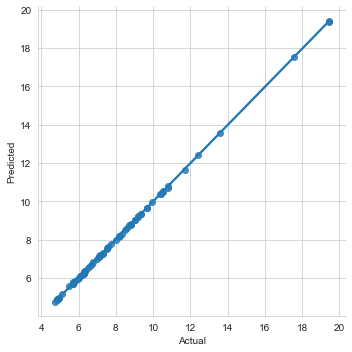

In [246]:
sns.set_style('whitegrid')
sns.lmplot(x ='Actual', y ='Predicted', data = true_pred_all_fre_hard_train)

### Test

In [247]:
true_pred_all_fre_hard_test= pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_pred),
                            pd.DataFrame(y_test)- pd.DataFrame(y_pred)], axis=1)
true_pred_all_fre_hard_test.columns =['Actual', 'Predicted','Residuals']
true_pred_all_fre_hard_test.head(3)

,Actual,Predicted,Residuals
0,6.641432,5.874668,0.766765
1,17.562160,17.680393,-0.118233
2,8.306680,7.580806,0.725874


Write the prediction in an Excel spreadsheet to visualize it with another tool.

In [248]:
# Write the prediction in an Excel sheet.
true_pred_all_fre_hard_test.to_excel("Model_4_Test_Output.xlsx",sheet_name='Test') 

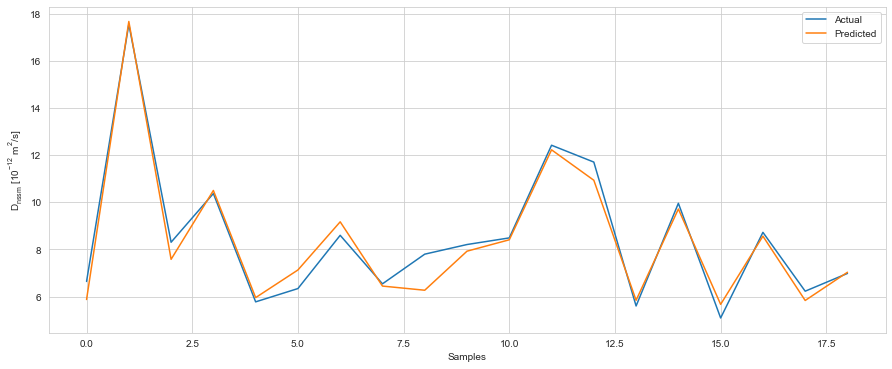

In [249]:
plt.figure(figsize=(15,6))
x_ax = range(len(y_test))
plt.plot(x_ax, true_pred_all_fre_hard_test.Actual, label="Actual")
plt.plot(x_ax, true_pred_all_fre_hard_test.Predicted, label="Predicted")
#plt.title("Non-steady migration coefficients ")
plt.xlabel("Samples")
plt.ylabel("$\mathregular{D_{nssm}}$ [$\mathregular{10^{-12}}$ $\mathregular{m^{2}/s}$]")
plt.legend()
plt.show()

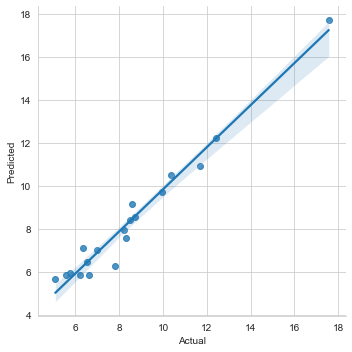

In [250]:
sns.set_style('whitegrid')
sns.lmplot(x ='Actual', y ='Predicted', data = true_pred_all_fre_hard_test)

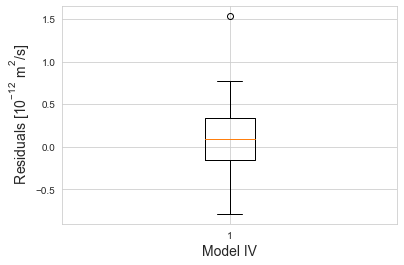

In [251]:
# Creating box plot
plt.boxplot(true_pred_all_fre_hard_test.Residuals)
#plt.title("Non-steady migration coefficients ")
plt.xlabel("Model IV",fontsize=14)
plt.ylabel(" Residuals [$\mathregular{10^{-12}}$ $\mathregular{m^{2}/s}$]",fontsize=14)
# show plot
plt.show()

#### Statistical validation metrics of the XGBoost models in the four scenarios considered

| Model         | MSE       |RMSE           | MAE       | $R^2$      | 
|---------------|--------------------|------------|--------------------|------------|
| Model I        |  9.992                |3.161        |  1.982                 | 0.830        | 
| Model II         |  1.243  	             |   1.115        |0.500                | 0.888       | 
| Model III         |  4.576  	             |  2.139        |  1.350               | 0.865      | 
| Model IV          | 0.307 	             | 0.554        |  0.416                 | 0.963     | 

## Concluding remarks

As demonstrated above, all models were validated using previously unseen data. The statistical performance indicators MSE, RMSE, MAE, and $R^2$, were utilized to assess the accuracy of the models, and the results confirmed that all XGBoost-based models were able to predict $D_{nssm}$ with a rationally small error. The performance of the XGBoost models was also compared to other tree-based models. It works best with Model II and IV. The superiority of Model IV confirms that the properties of fresh and hardened concrete, determined at an early age, are influential predictors of $D_{nssm}$. The features describing only the constituents of the concrete mix are also sufficient to predict the chloride migration coefficient with reasonable accuracy. The model is of great practical importance. Because the model was developed using a variety of concrete mixes from around the world, it can be used by concrete designers to evaluate the performance of their designed concrete against chloride resistance. It also has economic implications as it helps design optimal concrete mixes without the need for labor-intensive and resource- intensive laboratory testing. With the availability of more representative data, the proposed solution could replace the chloride migration coefficient of concrete, saving costs, time, and resources.